In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
cd '/content/drive/My Drive/CSE-544/Project/'

/content/drive/My Drive/CSE-544/Project


# import libraries

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime, math
import numpy as np
import seaborn as sns
from scipy.stats import gamma, binom, poisson
from statistics import variance

Possible Counties(MA State) Contention: 

All close to east coast and have high population densities.
High number of confirmed cases and deaths as well (Except for Plymouth, Barnstable)

1. Suffolk
2. Middlesex
3. Essex
4. Norfolk
5. Plymouth
6. Barnstable

# Task 1 and 2 (Cleaning)

In [137]:
#preprocessing occurs in multi steps

# load, basic process, save
def prepare_from_csv(filename):
  df = pd.read_csv(filename)
  df = df[df["State"] == 'MA'] # only MA state
  df = df.T # making date as index
  df.columns = df.iloc[1]
  df = df.drop(['countyFIPS', 'County Name', 'State', 'stateFIPS']) #unnecessary for us
  # index to column, to preserve Date while saving (without index)
  df['Date'] = df.index

  # keeping column Date ahead
  cols = df.columns.tolist()
  cols = cols[-1:] + cols[:-1]
  df = df[cols]
  return df

def preprocess(df):
  # filtered counties
  cols = ['Date', 'Barnstable County', 'Essex County', 'Middlesex County', 'Norfolk County','Plymouth County', 'Suffolk County']
  df = df[cols]
  df2 = df.copy()

  # reversing cumulative effect, making numbers occured each day
  for county in df.select_dtypes(include='int64').columns:
    vals = df[county].values
    df[county] = np.insert(vals[1:] - vals[:-1],0,vals[0])

  # data taken from 1st march, because before that almost no cases were there
  startdate = datetime.date(2020, 3, 1)
  df = df[pd.to_datetime(df['Date']) > pd.to_datetime(startdate)]
  df2 = df2[pd.to_datetime(df2['Date']) > pd.to_datetime(startdate)]

  return df, df2

# load, process, (run only once)
# confirmed = prepare_from_csv('CovidData/covid_confirmed_usafacts.csv')
# deaths = prepare_from_csv('CovidData/covid_deaths_usafacts.csv')

# # save (run only once)
# confirmed.to_csv('CovidData/MA_COVID_CONFIRMED.csv', index=False)
# deaths.to_csv('CovidData/MA_COVID_DEATHS.csv', index=False)

# load processed
confirmed = pd.read_csv('CovidData/MA_COVID_CONFIRMED.csv')
deaths = pd.read_csv('CovidData/MA_COVID_DEATHS.csv')
  
# filter counties, reverse cumulative effect, take data from 1st march
confirmed, confirmed2 = preprocess(confirmed)
deaths, deaths2 = preprocess(deaths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# just for temporary purpose to extract data

# how many weeks data do you want? check starting date for it!
# datetime.datetime(2020, 5, 6) - datetime.timedelta(weeks = 4)

In [0]:
# save it here

# startdate = datetime.date(2020, 4, 8)
# fourWeekDeaths = deaths[pd.to_datetime(deaths['Date']) > pd.to_datetime(startdate)]
# fourWeekConfirmed = confirmed[pd.to_datetime(confirmed['Date']) > pd.to_datetime(startdate)]

# fourWeekDeaths.to_csv('CovidData/' + 'lastfourWeekDeaths.csv', index=False)
# fourWeekConfirmed.to_csv('CovidData/' + 'lastfourWeekConfirmed.csv', index=False)

functions definitions

In [0]:
def applyTukeyRule(df, counties):

  # global list, carrying outliers per county (list of lists)
  outlier_list = []

  # iterate over counties
  for county in counties:
    
    Q1 = np.percentile(df[county], 25) # 1st quartile (25%)
    Q3 = np.percentile(df[county], 75) # 3rd quartile (75%)
    IQR = Q3 - Q1 # Interquartile range

    outlier_step = 2 * IQR

    # List of outliers for a single county
    outlier_list_county = df[(df[county] < Q1 - outlier_step) | (df[county] > Q3 + outlier_step)].index

    # outlier "indices" for a county to the global list 
    outlier_list.append(outlier_list_county)

    # dropping outlier record by each county iteration, so dates will remain same for all counties
    # df = df.drop(outlier_list_county)
  return df, outlier_list

def show_outliers(df, counties):

  print("Before removing outliers, total records", len(df))
  df, outliersLoL = applyTukeyRule(df, counties) #list of list
  print("After removing outliers, total records", len(df))
  print('*'*20)

  print("Outliers per County")
  print('*'*20)
  for i, county in enumerate(counties):
    print(county, '=>', len(outliersLoL[i]))
  print('*'*20)

  print("Same is shown using boxplot of pandas")
  plt.figure(figsize=(10,10))
  df.boxplot(column=list(counties))
  plt.xticks(rotation=70)
  plt.title("Outliers per county")

  return df

def show_growth(df, counties):
  plt.figure(figsize=(10,10))
  for county in counties:
    plt.plot(df['Date'], df[county], label=county)
  plt.legend()
  plt.title('Growth of numbers per county - PDF')
  plt.show()

  plt.figure(figsize=(10,10))
  for county in counties:
    plt.plot(df['Date'], df[county].cumsum(), label=county)
  plt.legend()
  plt.title('Growth of numbers per county - CDF')
  plt.show()
  

def process(df):
  df['Date'] = pd.to_datetime(df['Date'])

  df = df.sort_values('Date', ascending=True)
  
  print("Data is ranged from", df['Date'].min(), "to", df['Date'].max(), "where total", df['Date'].max() - df['Date'].min(), "are there.")

  counties = df.select_dtypes(include='int64').columns
  show_growth(df, counties)
  df = show_outliers(df, counties)

def visualize(dfs, counties):
  
  print("Lets see growth of confirmed cases and deaths in each counties from 1st March")
  confirmed_df = dfs[0]
  deaths_df = dfs[1]

  cols = 4
  rows = int(len(counties)/cols)-1
  
  fig, axes = plt.subplots(rows, cols, figsize=(15,10))
  fig.subplots_adjust(hspace=0.5)

  for ax, county in zip(axes.flatten(), counties):

    ax.plot(confirmed_df['Date'].dt.date, confirmed_df[county], label='confirmed')
    ax.plot(deaths_df['Date'].dt.date, deaths_df[county], label='deaths')
    ax.set_title(county)

    for tick in ax.get_xticklabels():
      tick.set_rotation(45)  
    ax.legend()
  plt.show()

## main work

Confirmed
*************************
*************************
Data is ranged from 2020-03-02 00:00:00 to 2020-05-06 00:00:00 where total 65 days 00:00:00 are there.


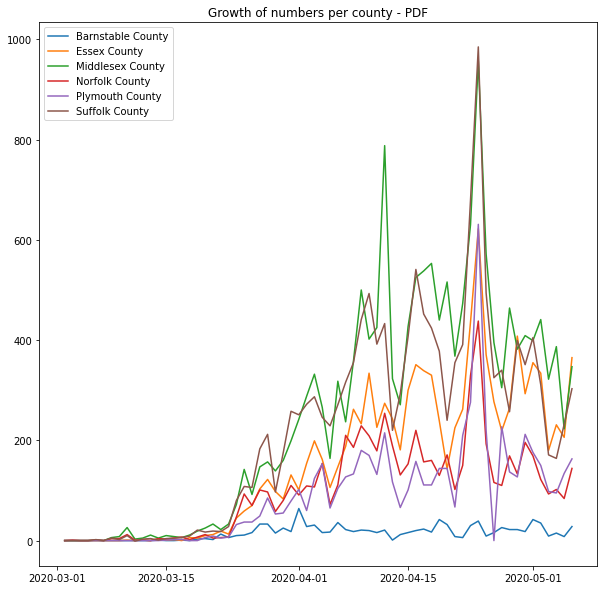

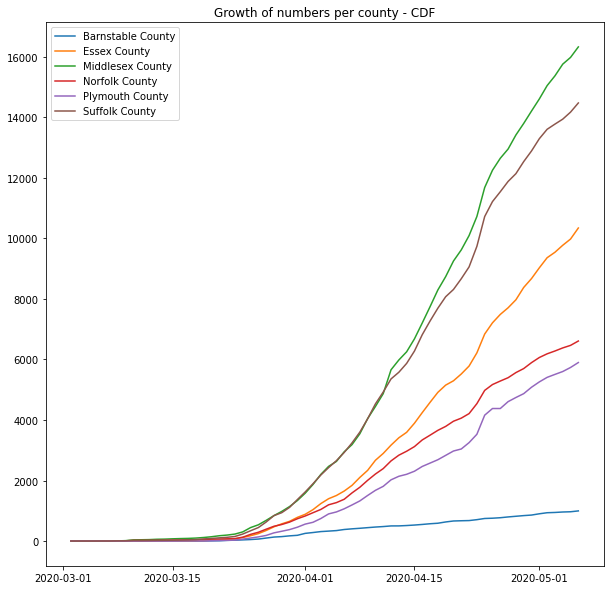

Before removing outliers, total records 66
After removing outliers, total records 66
********************
Outliers per County
********************
Barnstable County => 0
Essex County => 0
Middlesex County => 0
Norfolk County => 0
Plymouth County => 1
Suffolk County => 0
********************
Same is shown using boxplot of pandas
Deaths
*************************
*************************
Data is ranged from 2020-03-02 00:00:00 to 2020-05-06 00:00:00 where total 65 days 00:00:00 are there.


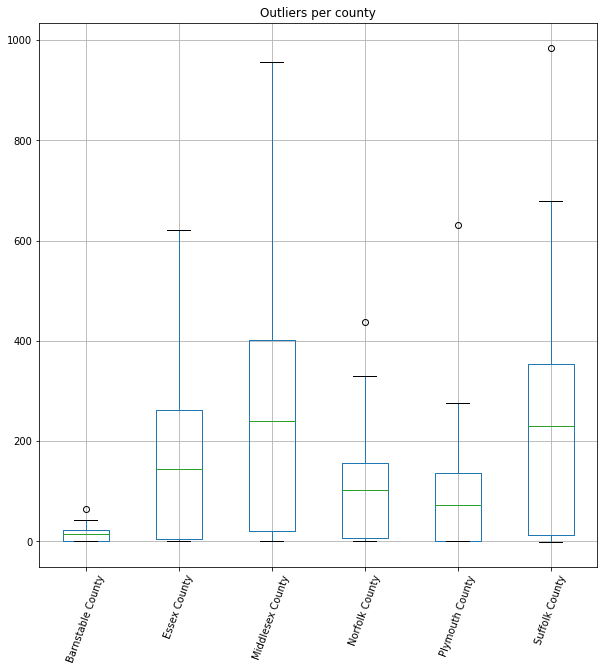

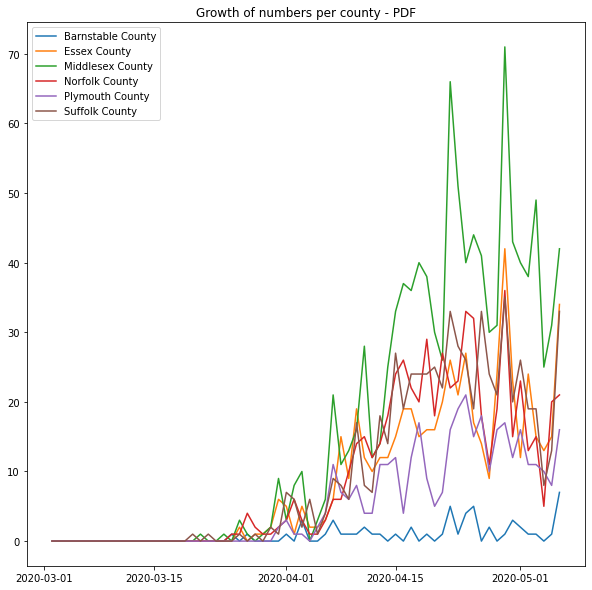

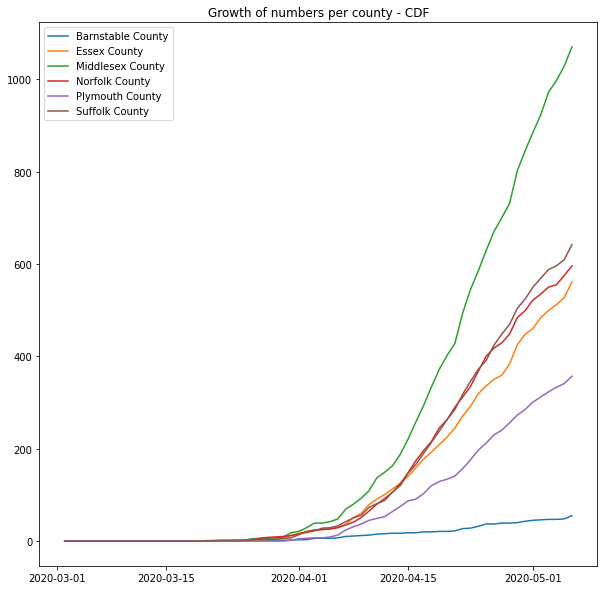

Before removing outliers, total records 66
After removing outliers, total records 66
********************
Outliers per County
********************
Barnstable County => 4
Essex County => 0
Middlesex County => 0
Norfolk County => 0
Plymouth County => 0
Suffolk County => 0
********************
Same is shown using boxplot of pandas


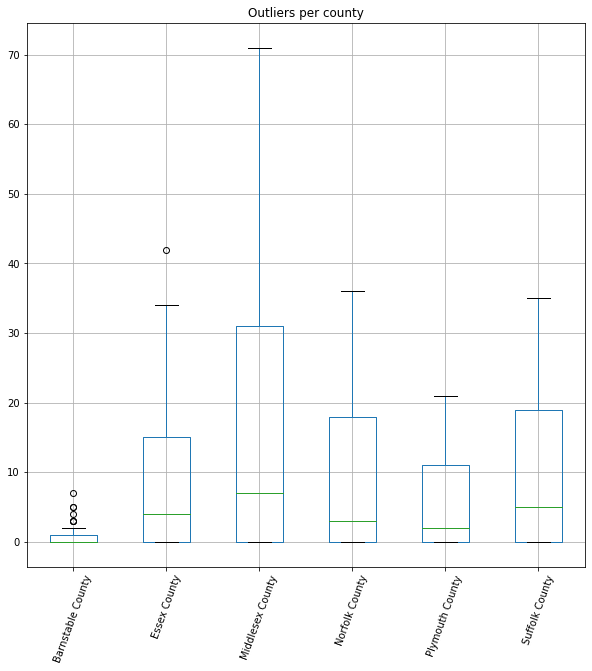

In [141]:
print("Confirmed")
print('*'*25)
print('*'*25)
process(confirmed)

print("Deaths")
print('*'*25)
print('*'*25)
process(deaths)

# Required Inference #1

## Pre-processing

In [0]:
#confirmed = pd.read_csv('MA_COVID_CONFIRMED.csv')
# confirmed = confirmed.rename(columns={'Unnamed: 0':'Date'})

In [0]:
# deaths = pd.read_csv('MA_COVID_DEATHS.csv')
# deaths = deaths.rename(columns={'Unnamed: 0':'Date'})

In [0]:
#Bring the dates to a standard format
# STD_DATE_FORMAT = '%m/%d/%Y'
# DATA_DATE_FORMAT = '%m/%d/%y'
# confirmed.Date = pd.to_datetime(confirmed.Date, format=DATA_DATE_FORMAT).dt.strftime(STD_DATE_FORMAT)
# deaths.Date = pd.to_datetime(deaths.Date, format=DATA_DATE_FORMAT).dt.strftime(STD_DATE_FORMAT)

In [0]:
#MA Counties chosen for analysis
SELECTED_COUNTIES = ['Suffolk County', 'Middlesex County', 'Essex County', 'Norfolk County', 'Plymouth County', 'Barnstable County']
# confirmed=confirmed[['Date']+SELECTED_COUNTIES]
# deaths=deaths[['Date']+SELECTED_COUNTIES]

In [146]:
deaths.tail()

,Date,Barnstable County,Essex County,Middlesex County,Norfolk County,Plymouth County,Suffolk County
101,2020-05-02,1,24,38,13,11,19
102,2020-05-03,1,15,49,15,11,19
103,2020-05-04,0,13,25,5,10,8
104,2020-05-05,1,15,31,20,8,13
105,2020-05-06,7,34,42,21,16,33


In [0]:
#Preprocessing data to have a consistent and standard format mm/dd/YYYY
def filter_dataframe(df, start_date_str):
  start_date = datetime.datetime.strptime(start_date_str,STD_DATE_FORMAT)
  delta = datetime.timedelta(days=27)
  end_date = start_date + delta
  end_date_str = end_date.strftime(STD_DATE_FORMAT)
  return df[(df.Date >= start_date_str) & (df.Date <= end_date_str)]

In [0]:
#Split 1 month data into 3 weeks : 1 week for train and test
def train_test_split(dframe):
  train_data = dframe.iloc[:dframe.shape[0]-7]
  test_data = dframe.iloc[dframe.shape[0]-7:]
  return (train_data, test_data)

**Base data for monthly time series prediction**

In [0]:
#Required dataset for Time Series Analysis of 1 month
reqd_df = filter_dataframe(confirmed, "04/01/2020")
reqd_death_df = filter_dataframe(deaths, "04/01/2020")

In [150]:
reqd_df.head()

,Date,Barnstable County,Essex County,Middlesex County,Norfolk County,Plymouth County,Suffolk County
70,2020-04-01,64,101,242,91,102,251
71,2020-04-02,28,154,288,109,60,272
72,2020-04-03,31,199,332,107,124,287
73,2020-04-04,16,162,266,154,153,246
74,2020-04-05,17,106,164,72,65,229


In [151]:
reqd_death_df.head()

,Date,Barnstable County,Essex County,Middlesex County,Norfolk County,Plymouth County,Suffolk County
70,2020-04-01,1,5,3,3,3,7
71,2020-04-02,0,1,8,6,1,6
72,2020-04-03,3,5,10,3,1,2
73,2020-04-04,0,2,0,1,0,6
74,2020-04-05,0,2,3,1,2,1


## MAPE

In [0]:
#Calculate Mean Absolute Prediction Error %
# E(MAPE) = [Sum({|Y-Y_hat|/Y}) * 100]/n
def calc_mape(test_df, pred_df):
  residuals = abs(test_df.sub(pred_df))
  percent_diff = (residuals.div(test_df)) * 100
  percent_diff = percent_diff.replace(np.inf, 0)
  mape_perc = percent_diff.sum().div(test_df.shape[0])
  cumulative_mape = percent_diff.values.sum()/(test_df.shape[0]*test_df.shape[1])
  return mape_perc, cumulative_mape

## MSE

In [0]:
#Calculate Mean Squared Error
# E(MSE) = [Sum(|Y-Y_hat|)^2]/n
def calc_mse(test_df, pred_df):
  residuals = test_df.sub(pred_df)
  res_sq = residuals ** 2
  res_sq_sum = res_sq.sum()
  mse = res_sq_sum.div(test_df.shape[0])
  cumulative_mse = res_sq_sum.values.sum()/(test_df.shape[0]*test_df.shape[1])
  return mse, cumulative_mse

## Exponentially Weighted Moving Avg

In [0]:
from math import pow

In [0]:
#EWMA 
#required parameters: train_data, test_data, alpha
#train_data, test_data: rows-dates, cols-county

#The logic below calculates the EWMA prediction for t and then goes from t to t+7 iteratively   
def calculate_ewma_coming_week(train_data, test_data, alpha):
  train_data_reqd = train_data.iloc[:train_data.shape[0]-1]
  train_len = train_data_reqd.shape[0]
  
  #Create a mask of [alpha, alpha(1-alpha), alpha(1-alpha)^2 ... alpha(1-alpha)^i] to multiply with t-i values
  alpha_mask = [alpha * pow((1.0-alpha),train_len-1-i) for i in range(train_len)]
  element_mul = train_data_reqd[SELECTED_COUNTIES].mul(alpha_mask, axis=0)
  
  #Cumulative sum to get the predicted value for t without the first term
  dot_product = element_mul.sum(axis=0)
  
  #predicted_t with the first term added
  predicted_t = dot_product +  train_data_reqd.iloc[0][SELECTED_COUNTIES] * pow((1.0-alpha),train_len)
  true_t = train_data.iloc[train_data.shape[0]-1][SELECTED_COUNTIES]
  

  ewma_df = pd.DataFrame(columns=SELECTED_COUNTIES)
  ewma_dt_series =  test_data.Date
  
  #prediction for next 7 days
  for ind in test_data.index:    
    predicted_t1 = alpha * true_t + (1.0 - alpha) * predicted_t
    true_t = test_data.loc[ind][SELECTED_COUNTIES]
    predicted_t = predicted_t1
    ewma_df.loc[ind] = predicted_t

  ewma_df.insert(0,'Date',ewma_dt_series)
  return ewma_df 
  

In [156]:
#Train Test Split for cases
train_cases, test_cases = train_test_split(reqd_df)
test_cases

,Date,Barnstable County,Essex County,Middlesex County,Norfolk County,Plymouth County,Suffolk County
91,2020-04-22,6,262,473,150,210,391
92,2020-04-23,30,436,630,329,276,679
93,2020-04-24,39,622,957,438,631,985
94,2020-04-25,9,371,572,193,220,494
95,2020-04-26,16,277,395,116,0,325
96,2020-04-27,26,219,305,110,227,340
97,2020-04-28,22,264,464,169,137,257


In [157]:
#Train Test split for deaths
train_death, test_death = train_test_split(reqd_death_df)
test_death


,Date,Barnstable County,Essex County,Middlesex County,Norfolk County,Plymouth County,Suffolk County
91,2020-04-22,5,26,66,22,16,33
92,2020-04-23,1,21,51,23,19,28
93,2020-04-24,4,27,40,33,21,26
94,2020-04-25,5,17,44,32,15,19
95,2020-04-26,0,14,41,18,18,33
96,2020-04-27,2,9,30,11,10,24
97,2020-04-28,0,24,31,19,16,21


**1) alpha = 0.5**

**1.1) Cases**

In [0]:
ewma_cases = calculate_ewma_coming_week(train_cases,test_cases,0.5)

In [159]:
ewma_cases

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,339.409661,433.777086,218.867452,130.855337,102.003332,19.556002
92,2020-04-23,365.204831,453.388543,240.433726,140.427669,156.001666,12.778001
93,2020-04-24,522.102415,541.694272,338.216863,234.713834,216.000833,21.389000
94,2020-04-25,753.551208,749.347136,480.108431,336.356917,423.500417,30.194500
95,2020-04-26,623.775604,660.673568,425.554216,264.678459,321.750208,19.597250
96,2020-04-27,474.387802,527.836784,351.277108,190.339229,160.875104,17.798625
97,2020-04-28,407.193901,416.418392,285.138554,150.169615,193.937552,21.899313


In [160]:
#MAPE
result = calc_mape(test_cases[SELECTED_COUNTIES], ewma_cases[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       49.834595
Middlesex County     37.328905
Essex County         36.912607
Norfolk County       57.588497
Plymouth County      46.266213
Barnstable County    88.353588
dtype: float64

Cumulative MAPE: 
52.71406733438793


In [161]:
#MSE
result = calc_mse(test_cases[SELECTED_COUNTIES], ewma_cases[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County       73236.446470
Middlesex County     51309.083526
Essex County         24650.932823
Norfolk County       18102.396054
Plymouth County      50119.598818
Barnstable County      188.561354
dtype: float64

Cumulative MSE: 
36267.83650743744


**1.2) Deaths**

In [0]:
ewma_deaths = calculate_ewma_coming_week(train_death,test_death,0.5)

In [163]:
ewma_deaths

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,23.114152,29.868278,18.038170,24.278209,7.542593,0.699759
92,2020-04-23,28.057076,47.934139,22.019085,23.139104,11.771297,2.849880
93,2020-04-24,28.028538,49.467069,21.509542,23.069552,15.385648,1.924940
94,2020-04-25,27.014269,44.733535,24.254771,28.034776,18.192824,2.962470
95,2020-04-26,23.007134,44.366767,20.627386,30.017388,16.596412,3.981235
96,2020-04-27,28.003567,42.683384,17.313693,24.008694,17.298206,1.990617
97,2020-04-28,26.001784,36.341692,13.156846,17.504347,13.649103,1.995309


In [164]:
#MAPE
result = calc_mape(test_death[SELECTED_COUNTIES], ewma_deaths[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       21.560621
Middlesex County     21.973166
Essex County         40.482572
Norfolk County       35.191409
Plymouth County      33.485426
Barnstable County    52.012716
dtype: float64

Cumulative MAPE: 
34.11765176436394


In [165]:
#MSE
result = calc_mse(test_death[SELECTED_COUNTIES], ewma_deaths[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County        43.854353
Middlesex County     229.400195
Essex County          53.974259
Norfolk County        62.203870
Plymouth County       32.322507
Barnstable County      7.171872
dtype: float64

Cumulative MSE: 
71.48784265416835


**2) alpha = 0.8**

**2.1) Cases**

In [0]:
ewma_cases = calculate_ewma_coming_week(train_cases,test_cases,0.8)

In [167]:
ewma_cases

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,337.951165,395.427905,213.181624,114.410965,82.147117,13.008314
92,2020-04-23,380.390233,457.485581,252.236325,142.882193,184.429423,7.401663
93,2020-04-24,619.278047,595.497116,399.247265,291.776439,257.685885,25.480333
94,2020-04-25,911.855609,884.699423,577.449453,408.755288,556.337177,36.296067
95,2020-04-26,577.571122,634.539885,412.289891,236.151058,287.267435,14.459213
96,2020-04-27,375.514224,442.907977,304.057978,140.030212,57.453487,15.691843
97,2020-04-28,347.102845,332.581595,236.011596,116.006042,193.090697,23.938369


In [168]:
#MAPE
result = calc_mape(test_cases[SELECTED_COUNTIES], ewma_cases[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       43.211381
Middlesex County     38.629608
Essex County         35.788819
Norfolk County       55.386789
Plymouth County      60.247873
Barnstable County    84.025131
dtype: float64

Cumulative MAPE: 
52.88160027517485


In [169]:
#MSE
result = calc_mse(test_cases[SELECTED_COUNTIES], ewma_cases[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County       67644.254826
Middlesex County     51130.383211
Essex County         22102.006376
Norfolk County       17426.363049
Plymouth County      55947.488755
Barnstable County      228.578196
dtype: float64

Cumulative MSE: 
35746.5124022134


**2.2 Deaths**

In [0]:
ewma_deaths = calculate_ewma_coming_week(train_death,test_death,0.8)

In [171]:
ewma_deaths

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,22.558750,27.129534,19.198105,25.572264,6.813936,0.834614
92,2020-04-23,30.911750,58.225907,24.639621,22.714453,14.162787,4.166923
93,2020-04-24,28.582350,52.445181,21.727924,22.942891,18.032557,1.633385
94,2020-04-25,26.516470,42.489036,25.945585,30.988578,20.406511,3.526677
95,2020-04-26,20.503294,43.697807,18.789117,31.797716,16.081302,4.705335
96,2020-04-27,30.500659,41.539561,14.957823,20.759543,17.616260,0.941067
97,2020-04-28,25.300132,32.307912,10.191565,12.951909,11.523252,1.788213


In [172]:
#MAPE
result = calc_mape(test_death[SELECTED_COUNTIES], ewma_deaths[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       25.280492
Middlesex County     22.410621
Essex County         39.083017
Norfolk County       35.475002
Plymouth County      35.406817
Barnstable County    77.368356
dtype: float64

Cumulative MAPE: 
39.170717457668516


In [173]:
#MSE
result = calc_mse(test_death[SELECTED_COUNTIES], ewma_deaths[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County        56.797313
Middlesex County     266.063243
Essex County          59.490725
Norfolk County        62.459440
Plymouth County       32.506941
Barnstable County      8.801517
dtype: float64

Cumulative MSE: 
81.01986310663062


**Comments**

---
1 month data from 1st April 2020 onwards was considered for the test.<br>
If we look at the MAPE and MSE values for EWMA Prediction, the numbers are pretty high for number of confrmed cases. This is first of all due to the highly fluctuating nature of the data and how EWMA works. For EWMA, the highest weight is given to prediction of day before which is < 1, so if the data is increasing which was the general trend due to increase in testing around April. <br>
On the other hand, the predictions for deaths were better, especially for MSE which could be due to a) Empiral factors resulting from less wildly fluctuating data such that the residual difference came to be low and b) An increase in testing does mean a pro-active approach towards treatment due to which the deaths would be on a downwards/approx. constant curve. <br>
Also, results for alpha=0.8 were slightly worse than alpha=0.5. This is again due to the fact that there were wid fluctuations in the confirmed cases and the values from day before are given the most importance. 

## Autoregression

In [0]:
from numpy.linalg import inv
#Auto-Regression 
#required parameters: train_data, test_data, alpha
#train_data, test_data: rows-dates, cols-county
def calculate_ar_coming_week(train_data, test_data):
  pred_list = []
  reqd_cols = [x for x in train_data.columns if x not in ['Date', 'Current']]
  train_feature_mat = train_data[reqd_cols].values
  grd_truth = train_data['Current']
  
  #Multi Linear regression optimization to estimate Beta
  for new_sample in range(test_data.shape[0]):
    train_feature_mat = train_feature_mat.astype(float)
    x_trans_x =  np.matmul(train_feature_mat.transpose(), train_feature_mat)
    x_trans_x_inv = inv(x_trans_x)
    inv_x_trans = np.matmul(x_trans_x_inv, train_feature_mat.transpose())
    beta_hat = np.matmul(inv_x_trans, grd_truth)
    test_feature_mat = test_data.iloc[new_sample][reqd_cols].values
    prediction = np.matmul(beta_hat, test_feature_mat)
    pred_list.append(prediction)
    train_feature_mat = np.concatenate((train_feature_mat, [test_feature_mat]))
    grd_truth = np.append(grd_truth,test_data.iloc[0]['Current'])
  return pred_list
  


In [0]:
#Create Feature DataFrame out of t-param date records and save them in a 
#dictionary keyed on County names

def create_ar_features(dframe, param):
  start_ind = param

  #Create rows as T_0, T_1..., T_param
  t_n_cols = ["T_"+str(i+1) for i in range(param)]
  ar_dframe_dic = dict()

  #Create Dataframe with previous values as features
  for county in SELECTED_COUNTIES:
    county_series = dframe[county]
    county_df = pd.DataFrame(columns=["Current"]+t_n_cols) 
    county_df["Current"] = county_series[param:]
    
    for i,col in enumerate(t_n_cols):
      county_df[col] = county_series.iloc[(param-i-1):(county_series.shape[0]-i-1)].values
    county_df.insert(0,'Date',dframe['Date'])  
    county_df.insert(1,'T_0',1)
    ar_dframe_dic[county] = county_df
  return ar_dframe_dic


In [0]:
#AR(p) in action
def calc_ar_w_param(reqd_df, param):
  ar_dframe_dic = create_ar_features(reqd_df, param)
  result_df = pd.DataFrame(columns=['Date'] + SELECTED_COUNTIES)

  for county in SELECTED_COUNTIES:
    ar_train, ar_test = train_test_split(ar_dframe_dic[county])
    predictions = calculate_ar_coming_week(ar_train,ar_test)
    result_df['Date'] = ar_test.Date
    result_df[county] = predictions
  return result_df  

**1) AR(3)**

**1.1) Cases**

In [0]:
ar_cases = calc_ar_w_param(reqd_df, 3)

In [178]:
ar_cases

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,347.774720,407.493383,227.474001,144.774769,114.931621,16.183521
92,2020-04-23,409.134352,469.890934,256.752170,164.939646,151.622097,19.729271
93,2020-04-24,544.294401,463.652309,352.831213,195.768038,103.174992,25.734200
94,2020-04-25,594.655738,573.833580,402.168734,207.376363,311.858692,21.301884
95,2020-04-26,308.743887,482.959652,264.998073,201.916526,86.066710,14.055793
96,2020-04-27,236.205367,562.800872,255.663817,216.351344,237.900142,19.616390
97,2020-04-28,356.852709,430.907084,236.740418,162.055693,166.319816,17.908203


In [179]:
#MAPE
result = calc_mape(test_cases[SELECTED_COUNTIES], ar_cases[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       27.185697
Middlesex County     29.294370
Essex County         19.623664
Norfolk County       41.565845
Plymouth County      34.563027
Barnstable County    61.423757
dtype: float64

Cumulative MAPE: 
35.609393268952594


In [180]:
#MSE
result = calc_mse(test_cases[SELECTED_COUNTIES], ar_cases[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County       42865.292273
Middlesex County     49802.095351
Essex County         15568.074531
Norfolk County       14938.083870
Plymouth County      45704.437283
Barnstable County       85.397568
dtype: float64

Cumulative MSE: 
28160.563479505927


**1.2) Deaths**

In [0]:
ar_deaths = calc_ar_w_param(reqd_death_df, 3)

In [182]:
ar_deaths

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,25.905443,28.464225,17.976441,24.712987,8.592114,1.058792
92,2020-04-23,27.179709,54.875008,24.160308,25.153554,11.963111,0.169577
93,2020-04-24,31.942328,37.030223,23.833126,23.289358,11.844345,0.079749
94,2020-04-25,33.662263,56.428767,25.213386,27.863581,16.305229,1.477084
95,2020-04-26,29.236899,56.164247,22.493000,30.404027,12.330891,4.975571
96,2020-04-27,27.609159,51.482781,16.596328,25.704638,18.004336,2.961476
97,2020-04-28,30.351032,46.642418,14.973219,17.455267,9.492470,2.410970


In [183]:
#MAPE
result = calc_mape(test_death[SELECTED_COUNTIES], ar_deaths[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       27.917629
Middlesex County     37.028105
Essex County         41.233093
Norfolk County       39.252500
Plymouth County      41.120844
Barnstable County    54.057835
dtype: float64

Cumulative MAPE: 
40.101667540448226


In [184]:
#MSE
result = calc_mse(test_death[SELECTED_COUNTIES], ar_deaths[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County        59.418226
Middlesex County     360.484777
Essex County          51.881697
Norfolk County        70.839585
Plymouth County       46.925769
Barnstable County     10.785078
dtype: float64

Cumulative MSE: 
100.0558552829318


**2) AR(5)**

**1.1) Cases**

In [0]:
ar_cases = calc_ar_w_param(reqd_df, 5)

In [186]:
ar_cases

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,359.616842,409.977663,241.302355,147.233266,118.780944,21.427653
92,2020-04-23,446.691871,478.403392,332.049479,175.225993,149.724208,13.557058
93,2020-04-24,536.713027,457.309448,373.650125,218.165215,121.588355,28.356473
94,2020-04-25,514.079828,541.113933,346.319236,204.409128,297.147444,26.233832
95,2020-04-26,352.408289,457.104345,274.881053,197.603423,125.162228,16.048276
96,2020-04-27,134.554522,530.853731,160.737055,212.389116,92.042316,19.601530
97,2020-04-28,265.260863,430.149700,206.516143,151.735340,184.152561,13.489263


In [187]:
#MAPE
result = calc_mape(test_cases[SELECTED_COUNTIES], ar_cases[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       23.412653
Middlesex County     27.438456
Essex County         18.209299
Norfolk County       39.761562
Plymouth County      42.694038
Barnstable County    84.901696
dtype: float64

Cumulative MAPE: 
39.40295050767236


In [188]:
#MSE
result = calc_mse(test_cases[SELECTED_COUNTIES], ar_cases[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County       42763.382819
Middlesex County     47658.663408
Essex County         11460.622611
Norfolk County       12793.188467
Plymouth County      46545.852581
Barnstable County      147.435406
dtype: float64

Cumulative MSE: 
26894.857548737793


**1.2) Deaths**

In [0]:
ar_deaths = calc_ar_w_param(reqd_death_df, 5)

In [190]:
ar_deaths

,Date,Suffolk County,Middlesex County,Essex County,Norfolk County,Plymouth County,Barnstable County
91,2020-04-22,25.720532,27.857098,19.858437,24.957347,12.059731,0.345856
92,2020-04-23,27.593486,56.043748,23.627403,26.904445,12.994361,0.286697
93,2020-04-24,31.305744,39.589902,23.074560,25.931849,8.168888,-0.363957
94,2020-04-25,33.637790,33.608070,21.760366,25.776400,10.769638,1.783760
95,2020-04-26,29.543109,65.904369,21.958248,29.949514,12.330947,6.580371
96,2020-04-27,31.387289,61.099273,19.472315,27.415229,18.787728,1.338281
97,2020-04-28,31.654441,52.703334,16.384119,20.223425,13.675082,2.840718


In [191]:
#MAPE
result = calc_mape(test_death[SELECTED_COUNTIES], ar_deaths[SELECTED_COUNTIES])
print('County-level MAPE:\n{}'.format(result[0]))
print('\nCumulative MAPE: \n{}'.format(result[1]))

County-level MAPE:
Suffolk County       30.421396
Middlesex County     46.677515
Essex County         40.515740
Norfolk County       41.905764
Plymouth County      39.920143
Barnstable County    52.988978
dtype: float64

Cumulative MAPE: 
42.07158951701823


In [192]:
#MSE
result = calc_mse(test_death[SELECTED_COUNTIES], ar_deaths[SELECTED_COUNTIES])
print('County-level MSE:\n{}'.format(result[0]))
print('\nCumulative MSE: \n{}'.format(result[1]))

County-level MSE:
Suffolk County        67.944427
Middlesex County     520.986833
Essex County          44.813848
Norfolk County        75.204279
Plymouth County       49.842052
Barnstable County     14.766715
dtype: float64

Cumulative MSE: 
128.92635902628646


**Comments**

---
The trends seen for EWMA repeat in Auto-regression as well. Although, overall the MAPE and MSE for confirmed case look a bit better than EWMA, the general picture looks the same.<br>
This can probably be attributed to the fact that rather than consider all the  previous months' values, only 3 or 5 previous data points are being considered. <br> 
Here too, the prediction metrics for deaths show a better result due to low variance in the data for a better part of April. <br>
Also, the weights calculated are based on minimizing the loss rather than choosing an alpha value which should lead to better results.  


# Required Inference #2 



In [0]:
#Preprocessing data to have a consistent and standar format mm/dd/YYYY
def filter_dataframe(df, start_date_str):
 start_date = datetime.datetime.strptime(start_date_str,STD_DATE_FORMAT)
 delta = datetime.timedelta(days=7)
 end_date = start_date + delta
 end_date_str = end_date.strftime(STD_DATE_FORMAT)
 return df[(df.Date >= start_date_str) & (df.Date <= end_date_str)]

In [0]:
#Classifying data into second last week and last week
confirmed_2ndlast_week = filter_dataframe(confirmed, "03/22/2020")
confirmed_final_week =  filter_dataframe(confirmed, "03/29/2020")
deaths_2ndlast_week = filter_dataframe(deaths, "03/22/2020")
deaths_final_week =  filter_dataframe(deaths, "03/29/2020")

In [0]:
confirmed_temp_last_week = confirmed_final_week[SELECTED_COUNTIES].diff()
confirmed_temp_second_last_week = confirmed_2ndlast_week[SELECTED_COUNTIES].diff()
deaths_temp_last_week = deaths_final_week[SELECTED_COUNTIES].diff()
deaths_temp_second_last_week = deaths_2ndlast_week[SELECTED_COUNTIES].diff()

confirmed_temp_last_week['Total'] = confirmed_temp_last_week.sum(axis = 1)
confirmed_temp_second_last_week['Total'] = confirmed_temp_second_last_week.sum(axis=1)
deaths_temp_last_week['Total'] = deaths_temp_last_week.sum(axis=1)
deaths_temp_second_last_week['Total'] = deaths_temp_second_last_week.sum(axis=1)

confirmed_last_week = confirmed_temp_last_week['Total'][1:]
confirmed_second_last_week = confirmed_temp_second_last_week['Total'][1:]
deaths_last_week = deaths_temp_last_week['Total'][1:]
deaths_second_last_week = deaths_temp_second_last_week['Total'][1:]

##INFERENCES FOR NUMBER OF DEATHS

Z TEST

In [196]:

def z_test(deaths1, deaths2):
  mean_deaths_last_week = deaths1.mean()
  mean_deaths_secondlast_week = deaths2.mean()
  variance_secondlast_week = deaths2.var()
  z_stat = abs((mean_deaths_last_week - mean_deaths_secondlast_week) / math.sqrt( variance_secondlast_week/ len(deaths1)))
  if z_stat > 1.96:
    print("Mean deaths for second last week and last week are different because of the z statistic value",z_stat,"is greater than alpha at 0.05")
  else:
    print("Mean deaths for second last week and last week are same because of the z statistic value",z_stat,"is less than alpha at 0.05")
  
z_test(deaths_last_week, deaths_second_last_week)

Mean deaths for second last week and last week are same because of the z statistic value 0.6405126152203484 is less than alpha at 0.05


Conclusion - \\
With the assumption that variance should be known and test is applicable only if n is large and the data is normally distributed, we can conclude that this test is infact applicable because all the assumptions hold true.

1 SAMPLE T TEST

In [197]:
def t_test_1sample(deaths1, deaths2):
  mean_deaths_secondlast_week = deaths2.mean()
  mean_deaths_last_week = deaths1.mean()
  variance_secondlast_week = deaths2.var()
  t_stat = abs((mean_deaths_secondlast_week - mean_deaths_last_week) / math.sqrt(variance_secondlast_week/ len(deaths1)))
  if t_stat > 2.447:
    print("Mean deaths for second last week and last week are different because of the t statistic value",t_stat,"is greater than alpha at 0.05")
  else:
    print("Mean deaths for second last week and last week are same because of the t statistic value",t_stat,"is less than alpha at 0.05")
  

t_test_1sample(deaths_last_week, deaths_second_last_week)

Mean deaths for second last week and last week are same because of the t statistic value 0.6405126152203484 is less than alpha at 0.05


Conclusion - \\
T test is applicable because it has no such assumptions but is useful when n is small. \\
Hence this test is also applicable here. 

2 SAMPLE UNPAIRED T TEST

In [198]:
def t_test_2sample_unpaired(deaths1, deaths2):
  mean_deaths_last_week = deaths1.mean()
  mean_deaths_secondlast_week = deaths2.mean()
  variance_last_week = deaths1.var()
  variance_secondlast_week = deaths1.var()
  t_stat = abs((mean_deaths_last_week - mean_deaths_secondlast_week) / math.sqrt( variance_last_week/ 7 + variance_secondlast_week/ len(deaths1)))
  if t_stat > 1.96:
    print("Mean deaths for second last week and last week are different because of the t statistic value",t_stat,"is greater than alpha at 0.05")
  else:
    print("Mean deaths for second last week and last week are same because of the t statistic value",t_stat,"is less than alpha at 0.05")
      

t_test_2sample_unpaired(deaths_last_week, deaths_second_last_week)

Mean deaths for second last week and last week are same because of the t statistic value 0.12887589588356851 is less than alpha at 0.05


Conclusion - 
In 2 sample unpaired T test both the distributions must be independent. \\
In this case the mean number of deaths in second last week are  independent on mean number of deaths in the last week. \\
Hence this test is also applicable.


2 SAMPLE PAIRED T TEST

In [199]:
def t_test_2sample_paired(deaths1, deaths2):
  mean_deaths_last_week = deaths1.mean()
  mean_deaths_secondlast_week = deaths2.mean()
  variance_last_week = deaths1.var()
  variance_secondlast_week = deaths2.var()
  difference = mean_deaths_last_week - mean_deaths_secondlast_week
  
  t_stat = abs(difference/ math.sqrt(variance_last_week/len(deaths1)))
  if t_stat > 1.96:
    print("Mean deaths for second last week and last week are different because of the t statistic value",t_stat,"is greater than alpha at 0.05")
  else:
    print("Mean deaths for second last week and last week are same because of the t statistic value",t_stat,"is less than alpha at 0.05")

t_test_2sample_paired(deaths_last_week, deaths_second_last_week)

Mean deaths for second last week and last week are same because of the t statistic value 0.1822580398215255 is less than alpha at 0.05


Conclusion - 
In 2 sample paired T test both the distributions must be dependent. \\
In this case the mean number of deaths in second last week are not dependent on the mean number of deaths in the last week. \\
Hence this test is not applicable.

1 SAMPLE WALDS TEST

In [200]:
def walds_test_1sample(deaths1, deaths2):
  mean_deaths_last_week = deaths1.mean()
  mean_deaths_secondlast_week = deaths2.mean()
  variance_last_week = deaths1.var()
  variance_secondlast_week = deaths2.var()
  walds_stat = abs((mean_deaths_secondlast_week - mean_deaths_last_week)/math.sqrt(mean_deaths_secondlast_week/len(deaths1)))
  if walds_stat > 1.96:
    print("Mean deaths for second last week and last week are different because of the walds statistic value",walds_stat,"is greater than alpha at 0.05")
  else:
    print("Mean deaths for second last week and last week are same because of the walds statistic value",walds_stat,"is less than alpha at 0.05")
      

walds_test_1sample(deaths_last_week, deaths_second_last_week)

Mean deaths for second last week and last week are different because of the walds statistic value 2.8284271247461903 is greater than alpha at 0.05


Conclusion - \\
In this the estimator must be asymptotically normal. \\
Here the assumptions holds true and hence this test is applicable here. 

2 SAMPLE WALDS TEST

In [201]:
def walds_test_2sample(deaths1, deaths2):
  mean_deaths_last_week = deaths1.mean()
  mean_deaths_secondlast_week = deaths2.mean()
  variance_last_week = deaths1.var()
  variance_secondlast_week = deaths2.var()
  walds_stat = abs((mean_deaths_secondlast_week - mean_deaths_last_week)/math.sqrt((mean_deaths_secondlast_week/len(deaths2)) + (mean_deaths_last_week/len(deaths1))))
  if walds_stat > 1.96:
    print("Mean deaths for second last week and last week are different because of the walds statistic value",walds_stat,"is greater than alpha at 0.05")
  else:
    print("Mean deaths for second last week and last week are same because of the t statistic value",walds_stat,"is less than alpha at 0.05")
  

walds_test_2sample(deaths_last_week, deaths_second_last_week)

Mean deaths for second last week and last week are same because of the t statistic value 1.4142135623730951 is less than alpha at 0.05


Conclusion - \\
In this both distributions must be independent and both the estimators must be asymptotically normal. Both these assumptions hold true in this case, hence this test is applicable. 

##INFERENCE FOR NUMBER OF CASES

Z TEST

In [202]:
def z_test(cases1, cases2):
  mean_cases_last_week = cases1.mean()
  mean_cases_secondlast_week = cases2.mean()
  variance_last_week = cases1.var()
  variance_secondlast_week = cases2.var()
  z_stat = abs((mean_cases_last_week - mean_cases_secondlast_week) / math.sqrt( variance_secondlast_week/ len(cases1)))
  if z_stat > 1.96:
    print("Mean cases for second last week and last week are different because of the z statistic value",z_stat,"is greater than alpha at 0.05")
  else:
    print("Mean cases for second last week and last week are same because of the z statistic value",z_stat,"is less than alpha at 0.05")
      

z_test(confirmed_last_week, confirmed_second_last_week)

Mean cases for second last week and last week are same because of the z statistic value 0.4177339723905385 is less than alpha at 0.05


Conclusion - \\
With the assumption that variance should be known and test is applicable only if n is large and the data is normally distributed, we can conclude that this test is infact applicable because all the assumptions hold true.

1 SAMPLE T TEST

In [203]:
def t_test_1sample(cases1, cases2):
  mean_cases_secondlast_week = cases2.mean()
  mean_cases_last_week = cases1.mean()
  variance_secondlast_week = cases2.var()
  t_stat = abs((mean_cases_secondlast_week - mean_cases_last_week) / math.sqrt(variance_secondlast_week/ len(cases1)))
  if t_stat > 2.447:
    print("Mean cases for second last week and last week are different because of the t statistic value",t_stat,"is greater than alpha at 0.05")
  else:
    print("Mean cases for second last week and last week are same because of the t statistic value",t_stat,"is less than alpha at 0.05")

t_test_1sample(confirmed_last_week, confirmed_second_last_week)

Mean cases for second last week and last week are same because of the t statistic value 0.4177339723905385 is less than alpha at 0.05


Conclusion - \\
T test is applicable because it has no such assumptions but is useful when n is small. \\
Hence this test is also applicable here. 

2 SAMPLE UNPAIRED T TEST

In [204]:

def t_test_2sample_unpaired(cases1, cases2):
  mean_cases_secondlast_week = cases2.mean()
  mean_cases_last_week = cases1.mean()
  variance_secondlast_week = cases2.var()
  variance_last_week = cases1.var()
  t_stat = abs((mean_cases_last_week - mean_cases_secondlast_week) / math.sqrt( variance_last_week/ len(cases2) + variance_secondlast_week/ len(cases1)))
  if t_stat > 1.96:
    print("Mean cases for second last week and last week are different because of the t statistic value",t_stat,"is greater than alpha at 0.05")
  else:
    print("Mean cases for second last week and last week are same because of the t statistic value",t_stat,"is less than alpha at 0.05")
      

t_test_2sample_unpaired(confirmed_last_week, confirmed_second_last_week)

Mean cases for second last week and last week are same because of the t statistic value 0.2754365511142155 is less than alpha at 0.05


Conclusion - 
In 2 sample unpaired T test both the distributions must be independent. \\
In this case the mean number of deaths in second last week are  independent on mean number of deaths in the last week. \\
Hence this test is also applicable.


2 SAMPLE PAIRED T TEST

In [205]:
def t_test_2sample_paired(cases1, cases2):
  mean_cases_secondlast_week = cases2.mean()
  mean_cases_last_week = cases1.mean()
  variance_secondlast_week = cases2.var()
  variance_last_week = cases1.var()
  t_stat = abs((mean_cases_last_week - mean_cases_secondlast_week) / math.sqrt( variance_last_week/ len(cases1)))
  if t_stat > 1.96:
    print("Mean cases for second last week and last week are different because of the t statistic value",t_stat,"is greater than alpha at 0.05")
  else:
    print("Mean cases for second last week and last week are same because of the t statistic value",t_stat,"is less than alpha at 0.05")
      
t_test_2sample_paired(confirmed_last_week, confirmed_second_last_week)

Mean cases for second last week and last week are same because of the t statistic value 0.36635557893726833 is less than alpha at 0.05


Conclusion - 
In 2 sample paired T test both the distributions must be dependent. \\
In this case the mean number of deaths in second last week are not dependent on the mean number of deaths in the last week. \\
Hence this test is not applicable.

1 SAMPLE WALDS TEST

In [206]:
def walds_test_1sample(cases1, cases2):
  mean_cases_secondlast_week = cases2.mean()
  mean_cases_last_week = cases1.mean()
  variance_secondlast_week = cases2.var()
  variance_last_week = cases1.var()
  walds_stat = abs((mean_cases_secondlast_week - mean_cases_last_week)/math.sqrt(mean_cases_secondlast_week/len(cases1)))
  if walds_stat > 1.96:
    print("Mean cases for second last week and last week are different because of the walds statistic value",walds_stat,"is greater than alpha at 0.05")
  else:
    print("Mean cases for second last week and last week are same because of the walds statistic value",walds_stat,"is less than alpha at 0.05")
    

walds_test_1sample(confirmed_last_week, confirmed_second_last_week)

Mean cases for second last week and last week are different because of the walds statistic value 9.476482128292727 is greater than alpha at 0.05


Conclusion - \\
In this the estimator must be asymptotically normal. \\
Here the assumptions holds true and hence this test is applicable here. 

2 SAMPLE WALDS TEST

In [207]:
def walds_test_2sample(cases1, cases2):
  mean_cases_secondlast_week = cases2.mean()
  mean_cases_last_week = cases1.mean()
  variance_secondlast_week = cases2.var()
  variance_last_week = cases1.var()
  walds_stat = abs((mean_cases_secondlast_week - mean_cases_last_week)/math.sqrt((mean_cases_secondlast_week/len(cases2)) + (mean_cases_last_week/len(cases1))))
  if walds_stat > 1.96:
    print("Mean cases for second last week and last week are different because of the walds statistic value",walds_stat,"is greater than alpha at 0.05")
  else:
    print("Mean cases for second last week and last week are same because of the walds statistic value",walds_stat,"is less than alpha at 0.05")
    

walds_test_2sample(confirmed_last_week, confirmed_second_last_week)

Mean cases for second last week and last week are different because of the walds statistic value 7.706911912567196 is greater than alpha at 0.05


Conclusion - \\
In this both distributions must be independent and both the estimators must be asymptotically normal. Both these assumptions hold true in this case, hence this test is applicable. 

# Required Inference #3





Prepare Data

In [0]:

confirmed_last_week = confirmed.tail(7)
confirmed_second_last_week = confirmed.tail(14).head(7)
deaths_last_week = deaths.tail(7)
deaths_second_last_week = deaths.tail(14).head(7)

In [209]:
confirmed.tail()

,Date,Barnstable County,Essex County,Middlesex County,Norfolk County,Plymouth County,Suffolk County
101,2020-05-02,35,334,441,122,150,311
102,2020-05-03,9,180,322,93,98,171
103,2020-05-04,15,231,387,102,95,164
104,2020-05-05,8,206,223,84,134,232
105,2020-05-06,28,365,347,144,163,303


In [0]:
def calc_cdf(SeriesA, SeriesB=[], draw=False):
  # Calculates cdf for seriesA and seriesB with optional plot. 
  # Input - One or Two series
  # Output - Sorted SeriesA, Series A cdf, [if two series] Sorted Series B, Series B cdf


  na = len(SeriesA)
  SeriesA_sorted = sorted(SeriesA)
  
  delta = .1
  X_seriesA = [min(SeriesA_sorted)-delta]
  Y_seriesA = [0]
  
  for i in range(0, na):
      X_seriesA = X_seriesA + [SeriesA_sorted[i], SeriesA_sorted[i]]
      Y_seriesA = Y_seriesA + [Y_seriesA[len(Y_seriesA)-1], Y_seriesA[len(Y_seriesA)-1]+(1/na)]
  X_seriesA = X_seriesA + [max(SeriesA_sorted)+delta]
  Y_seriesA = Y_seriesA + [1]
  if SeriesB:
    nb = len(SeriesB)
    SeriesB_sorted = sorted(SeriesB)
    X_seriesB = [min(SeriesB_sorted)-delta]
    Y_seriesB = [0]
    for i in range(0, nb):
        X_seriesB = X_seriesB + [SeriesB_sorted[i], SeriesB_sorted[i]]
        Y_seriesB = Y_seriesB + [Y_seriesB[len(Y_seriesB)-1], Y_seriesB[len(Y_seriesB)-1]+(1/nb)]
    X_seriesB = X_seriesB + [max(SeriesB_sorted)+delta]
    Y_seriesB = Y_seriesB + [1]


  # The above portion of cdf calculation is taken from the code that professor shared.
  # https://www3.cs.stonybrook.edu/~anshul/courses/cse544_s20/eCDF.py
  if draw:
    plt.figure('eCDF')
    plt.plot(X_seriesA, Y_seriesA ,label='eCDF')
    if SeriesB:
      plt.plot(X_seriesB, Y_seriesB ,label='eCDF 2')
    plt.xlabel('x')
    plt.ylabel('Pr[X<=x]')
    plt.title('eCDF of Series A and Series B')
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()


  # Returns X_seriesA (sorted Series A), Y_seriesA (cdf of seriesA), X_seriesB (sorted Series B), Y_seriesB (cdf of series B)
  if SeriesB:
    return X_seriesA, Y_seriesA, X_seriesB, Y_seriesB
  else:
    return X_seriesA, Y_seriesA, _, _



def post_process_cdf(a, b=[], c=[], d=[]):
  # Post process cdf data from calc cdf. Contains multiple values.
  # This is required because the calc_cdf function give multiple value for plotting purposes.
  # This cdf and sorted data is used further for KS tests.

  if a:
  
    a = a[::2]
    a = a[1:]
  if b: 
    b = b[::2]
    b = b[1:]
  if c:
    c = c[::2]
    c = c[1:]
  if d:
    d = d[::2]
    d = d[1:]
  
  return a, b, c, d

def find_nearest(a,v):
  # Given an array a, find nearest value v in it and return its index.

  idx = np.searchsorted(a, v, side="left")
  if idx > 0 and (v > a[idx-1]) and (v < a[idx]):
      return (idx-1)
  else:
      return (idx)


plt.rcParams["figure.figsize"] = (20,10)
def calc_KS(X1, X1cdf, Y1, Y1cdf,show_table=False):
  # Calculates D value of the of two series X1, Y1 with cdf value as X1cdf and Y1cdf respectively.

  nx = len(X1)
  ny = len(Y1)
  if nx <= ny:
    X = X1
    Y = Y1
    FX = X1cdf
    FY = Y1cdf
  else:
    X = Y1
    FX = Y1cdf
    Y = X1
    FY = X1cdf
  # Remember FX is me, the smaller(in terms of length) distribution [X], FY is the other distribution.
  # Fx is where me(X) stands in the other distribution(Y)
  x = []
  Fx = []
  Fy_left = []
  Fy_right = []
  F_left_diff = []
  F_right_diff = []

  for i in range(len(X)):
    
    x.append(X[i])
    if X[i]<min(Y):
      Fx.append(0)
    elif X[i]>max(Y):
      Fx.append(1)

    else:
      index_of_nearest = find_nearest(Y,X[i])
      Fx.append(FY[index_of_nearest])
    if i==0:
      Fy_left.append(0)
      Fy_right.append(FX[i])
    else:
      Fy_left.append(FX[i-1])
      Fy_right.append(FX[i])
    
    if X[i] not in Y:
      F_left_diff.append(abs(Fy_left[i]-Fx[i]))
      F_right_diff.append(abs(Fy_right[i]-Fx[i]))
    else:
      
      #Get the index of the element in the other distribution for edge cases
      i_y = Y.index(X[i])
      
      #There are total 9 cases to cover considering combinatation of (i=0, i!=0, i==n-1) for both x and y.
      if i == 0:
        if i_y ==0: 
          # if i = 0 and i_y = 0, left = 0 [L:1/9]
          F_left_diff.append(0)
        else: 
          # if i = 0 and i_y != 0, and i_y==(ny-1) : left is simply the other cdf. [L:3/9]
          F_left_diff.append(abs(FY[i_y-1]))
        
        if i_y+1>=len(Y):
          # if i= 0 and i_y==n-1, right = 1 - my cdf [R:1/9]
          F_right_diff.append(abs(1-FX[i]))  
        else:
          # if i= 0, i_y = 0 or i_y = != (ny-1) ; right = base case[R: 3/9]
          F_right_diff.append(abs(FX[i+1]-FY[i_y+1]))
      else: 
        
        if i_y==0: 
          # i!=0 , i_y=0 ; left = whatever current distribution had since the other hasnt staretd: [L:5/9]
          F_left_diff.append(abs(FX[i-1]))
        else:
          # i!=0, i_y can be any non-zero; left = proper case; [L:9/9]
          F_left_diff.append(abs(FX[i-1]-FY[i_y-1]))

        if i+1>=len(X) and i_y+1>=len(Y):  
          # i= nx-1 and i_y= ny -1; right: both have ended, so right = 0; [R:4/9]
          F_right_diff.append(0)
        elif i+1>=len(X):
          # i==nx-1 and i_y!=0; right = 1 - other cdf ; [R:6/9]
          F_right_diff.append(abs(1-FY[i_y]))

        elif i_y+1>=len(Y):
          # i_y=ny-1 and i!=0; right = 1 - my cdf since current ended; [R:7/9]
          F_right_diff.append(abs(1-FX[i]))  
          
        else:
          # i!=0, i_y!=ny-1, right = proper case: [R:9/9]
          F_right_diff.append(abs(FX[i+1]-FY[i_y+1]))

      
  d = pd.DataFrame(pd.Series(x))
  d.columns = ['x']
  d['Fx'] = Fx
  d['Fy_left'] = Fy_left
  d['Fy_right'] = Fy_right
  d['F_left_diff'] = F_left_diff
  
  d['F_right_diff'] = F_right_diff
  if show_table:
    print(d)
  # print("D: {}".format(max(F_left_diff + F_right_diff)))

  m = max(F_left_diff + F_right_diff)

  try:
    ai = F_left_diff.index(m)
  except:
    ai = F_right_diff.index(m)
  x1,x2 = x[ai], x[ai]
  y1,y2 = Fy_right[ai], Fx[ai]


  # Returns m as maxium value(D), (x1,y1) and (x2,y2) points between which there is maximum difference.
  return m, x1, x2, y1, y2
  
def KS( listA, listB, C, draw=False,message=""):
  if message:
    print(message)
  A, Acdf, B, Bcdf = calc_cdf(listA, listB, draw=draw)
  A, Acdf, B, Bcdf = post_process_cdf(A, Acdf, B, Bcdf)
  D, x1, x2, y1, y2 = calc_KS(A, Acdf, B, Bcdf,show_table=False)
  if D >= C:
    print("Rejecting null hypothesis because D value = {} greater than or equal to {}.".format(D, C))
    result = "Reject"
  else:
    print("Accepting null hypothesis because D value = {} less than {}.".format(D, C))
    result = "Accept"
  return D, result

1 - sample KS

In [0]:


def calc_poisson_cdf(param, x):
  v = 0
  for i in range(x+1):
    v+= math.exp(-param) * math.pow(param, i)/math.factorial(i)
  return v   

def calc_geometric_cdf(param,x) :
  return 1 - math.pow((1-param), x)

def calc_1_sample_KS(X1, X1cdf, name, params, show_table=False):
  # Calculates D value of the of two series X1, Y1 with cdf value as X1cdf and Y1cdf respectively.

  
  nx = len(X1)
  # print("Distribution: {}, Params: {} ".format(name, params))  
  X = X1
  FX = X1cdf
  x = []
  Fx = []
  Fy_left = []
  Fy_right = []
  F_left_diff = []
  F_right_diff = []

  for i in range(len(X)):
    x.append(X[i])
    if name=="Binomial":
      if X[i]<0:
        Fx.append(0)
      elif X[i]>params['n']:
        Fx.append(1)
      else:
        nearest = binom.cdf(X[i], params['n'], params['p'])
        Fx.append(nearest)
    elif name=="Poisson":
      if X[i]<0:
        Fx.append(0)
      else:
        nearest = poisson.cdf(X[i],params['lambda'])
        Fx.append(nearest)
    elif name=="Geometric":
      if X[i]<0:
        Fx.append(0)
      else:
        nearest = calc_geometric_cdf(params['p'], X[i])
        Fx.append(nearest)
    
    if i==0:
      Fy_left.append(0)
      Fy_right.append(FX[i])
    else:
      Fy_left.append(FX[i-1])
      Fy_right.append(FX[i])
    
    
    F_left_diff.append(abs(Fy_left[i]-Fx[i]))
    F_right_diff.append(abs(Fy_right[i]-Fx[i]))
    
      
  d = pd.DataFrame(pd.Series(x))
  d.columns = ['x']
  d['Fx'] = Fx
  d['Fy_left'] = Fy_left
  d['Fy_right'] = Fy_right
  d['F_left_diff'] = F_left_diff
  d['F_right_diff'] = F_right_diff
  if show_table:
    print(d)
  # print("D: {}".format(max(F_left_diff + F_right_diff)))

  m = max(F_left_diff + F_right_diff)  
  return m


In [0]:
def format_params(d):
  for k in list(d.keys()):
    v = float("{:.2f}".format(d[k]))
    d[k]=v
  return d

def KS_1_sample(county_name, county_data_second_last_week, county_data_last_week , C):
  
  if county_data_second_last_week.mean() == 0:
    print("County: {} - No Data for this county.\n".format(county))
    return -1, "Mean=0"
  else:
    print("County: {}\n".format(county))
    poisson_lambda_mme = county_data_second_last_week.mean()
    geometric_p_mme = 1/county_data_second_last_week.mean()
    binomial_p_mme = 1 - (county_data_second_last_week.var()/county_data_second_last_week.mean())
    binomial_n_mme = county_data_second_last_week.mean()/binomial_p_mme
    uniform_a_mle = min(county_data_second_last_week)
    uniform_b_mle = max(county_data_second_last_week)
    
    distribution_and_args={
        # "Binomial":{'p':float("{:.2f}".format(binomial_p_mme)), 'n': math.ceil(binomial_n_mme)},
        "Binomial":{'p':binomial_p_mme, 'n': math.ceil(binomial_n_mme)},
        # "Geometric":{'p':float("{:.2f}".format(geometric_p_mme))},
        "Geometric":{'p':geometric_p_mme},
        # "Poisson":{"lambda":float("{:.2f}".format(poisson_lambda_mme))
        "Poisson":{"lambda":poisson_lambda_mme}


    }
    A, Acdf, B, Bcdf = calc_cdf(county_data_last_week.tolist(), draw=False) 
    A, Acdf, B, Bcdf = post_process_cdf(A, Acdf, c = [], d= [])
    
    counties=[]
    distData = {}
    for d in list(distribution_and_args.keys()):
      D = calc_1_sample_KS(A, Acdf, d,distribution_and_args[d], show_table=False)
      print("Null hypthesis: Last week data follow a {} distribution with parameters {}\n".format(d,distribution_and_args[d]))
      if D >= C:
        print("Rejecting null hypothesis because D value = {} greater than or equal to {}.".format(D, C))
        result = "Reject"
      else:
        print("Accepting null hypothesis because D value = {} less than {}.".format(D, C))
        result = "Accept"
      print("--------------------------\n")
      testResult = {"Params":format_params(distribution_and_args[d]),"Result":result, "D":D}
      distData[d]=testResult
    return D, distData

In [0]:
county_names=list(filter(lambda x: "County" in x, deaths_last_week.columns.to_list()))

In [214]:
binomial_params = []
binomial_D = []
binomial_result = []
geometric_params = []
geometric_D = []
geometric_result = []
poisson_params = []
poisson_D = []
poisson_result = []
for county in county_names:
  print("####################################################################")
  D, distData = KS_1_sample(county, deaths_second_last_week[county],deaths_last_week[county],0.05)
  if D==-1:
    binomial_params.append(distData)
    geometric_params.append(distData)
    poisson_params.append(distData)
    binomial_D.append("-")
    binomial_result.append("-")
    poisson_D.append("-")
    poisson_result.append("-")		
    geometric_D.append("-")
    geometric_result.append("-")		
  else:
    binomial_params.append("{}".format(distData["Binomial"]["Params"]));
    binomial_D.append("{:.2f}".format(distData["Binomial"]["D"]));
    binomial_result.append("{} null".format(distData["Binomial"]["Result"]));

    geometric_params.append("{}".format(distData["Geometric"]["Params"]));
    geometric_D.append("{:.2f}".format(distData["Geometric"]["D"]));
    geometric_result.append("{} null".format(distData["Geometric"]["Result"]));

    poisson_params.append("{}".format(distData["Poisson"]["Params"]));
    poisson_D.append("{:.2f}".format(distData["Poisson"]["D"]));
    poisson_result.append("{} null".format(distData["Poisson"]["Result"]));

one_sample=pd.DataFrame(county_names)
one_sample.columns = ['County']
one_sample['Binomial Params'] = pd.DataFrame(binomial_params);
one_sample['Binomial D'] = pd.DataFrame(binomial_D);
one_sample['Binomial Result'] = pd.DataFrame(binomial_result);
one_sample['Poisson Params'] = pd.DataFrame(poisson_params);
one_sample['Poisson D'] = pd.DataFrame(poisson_D);
one_sample['Poisson Result'] = pd.DataFrame(poisson_result);
one_sample['Geometric Params'] = pd.DataFrame(geometric_params);
one_sample['Geometric D'] = pd.DataFrame(geometric_D);
one_sample['Geometric Result'] = pd.DataFrame(geometric_result);

one_sample
  

####################################################################
County: Barnstable County

Null hypthesis: Last week data follow a Binomial distribution with parameters {'p': -1.0512820512820515, 'n': -1}

Rejecting null hypothesis because D value = 1 greater than or equal to 0.05.
--------------------------

Null hypthesis: Last week data follow a Geometric distribution with parameters {'p': 0.5384615384615384}

Rejecting null hypothesis because D value = 0.3956043956043956 greater than or equal to 0.05.
--------------------------

Null hypthesis: Last week data follow a Poisson distribution with parameters {'lambda': 1.8571428571428572}

Rejecting null hypothesis because D value = 0.30319441518848894 greater than or equal to 0.05.
--------------------------

####################################################################
County: Essex County

Null hypthesis: Last week data follow a Binomial distribution with parameters {'p': -4.212121212121212, 'n': -5}

Rejecting null hypo

,County,Binomial Params,Binomial D,Binomial Result,Poisson Params,Poisson D,Poisson Result,Geometric Params,Geometric D,Geometric Result
0,Barnstable County,"{'p': -1.05, 'n': -1.0}",1.00,Reject null,{'lambda': 1.86},0.30,Reject null,{'p': 0.54},0.40,Reject null
1,Essex County,"{'p': -4.21, 'n': -5.0}",1.00,Reject null,{'lambda': 22.0},0.49,Reject null,{'p': 0.05},0.43,Reject null
2,Middlesex County,"{'p': -3.42, 'n': -12.0}",1.00,Reject null,{'lambda': 44.0},0.38,Reject null,{'p': 0.02},0.44,Reject null
3,Norfolk County,"{'p': -2.51, 'n': -9.0}",1.00,Reject null,{'lambda': 24.57},0.58,Reject null,{'p': 0.04},0.38,Reject null
4,Plymouth County,"{'p': 0.26, 'n': 65.0}",0.61,Reject null,{'lambda': 16.57},0.56,Reject null,{'p': 0.06},0.39,Reject null
5,Suffolk County,"{'p': -0.32, 'n': -84.0}",1.00,Reject null,{'lambda': 26.57},0.60,Reject null,{'p': 0.04},0.28,Reject null


Confirmed Cases

In [215]:
binomial_params = []
binomial_D = []
binomial_result = []
geometric_params = []
geometric_D = []
geometric_result = []
poisson_params = []
poisson_D = []
poisson_result = []
for county in county_names:
  print("####################################################################")
  D, distData = KS_1_sample(county, confirmed_second_last_week[county],confirmed_last_week[county],0.05)
  if D==-1:
    binomial_params.append(distData)
    geometric_params.append(distData)
    poisson_params.append(distData)
    binomial_D.append("-")
    binomial_result.append("-")
    poisson_D.append("-")
    poisson_result.append("-")		
    geometric_D.append("-")
    geometric_result.append("-")		
  else:
    binomial_params.append("{}".format(distData["Binomial"]["Params"]));
    binomial_D.append("{:.2f}".format(distData["Binomial"]["D"]));
    binomial_result.append("{} null".format(distData["Binomial"]["Result"]));

    geometric_params.append("{}".format(distData["Geometric"]["Params"]));
    geometric_D.append("{:.2f}".format(distData["Geometric"]["D"]));
    geometric_result.append("{} null".format(distData["Geometric"]["Result"]));

    poisson_params.append("{}".format(distData["Poisson"]["Params"]));
    poisson_D.append("{:.2f}".format(distData["Poisson"]["D"]));
    poisson_result.append("{} null".format(distData["Poisson"]["Result"]));

one_sample=pd.DataFrame(county_names)
one_sample.columns = ['County']
one_sample['Binomial Params'] = pd.DataFrame(binomial_params);
one_sample['Binomial D'] = pd.DataFrame(binomial_D);
one_sample['Binomial Result'] = pd.DataFrame(binomial_result);
one_sample['Poisson Params'] = pd.DataFrame(poisson_params);
one_sample['Poisson D'] = pd.DataFrame(poisson_D);
one_sample['Poisson Result'] = pd.DataFrame(poisson_result);
one_sample['Geometric Params'] = pd.DataFrame(geometric_params);
one_sample['Geometric D'] = pd.DataFrame(geometric_D);
one_sample['Geometric Result'] = pd.DataFrame(geometric_result);

one_sample
  

####################################################################
County: Barnstable County

Null hypthesis: Last week data follow a Binomial distribution with parameters {'p': -2.9817073170731705, 'n': -7}

Rejecting null hypothesis because D value = 1 greater than or equal to 0.05.
--------------------------

Null hypthesis: Last week data follow a Geometric distribution with parameters {'p': 0.042682926829268296}

Rejecting null hypothesis because D value = 0.29458216629401257 greater than or equal to 0.05.
--------------------------

Null hypthesis: Last week data follow a Poisson distribution with parameters {'lambda': 23.428571428571427}

Rejecting null hypothesis because D value = 0.41791668072366306 greater than or equal to 0.05.
--------------------------

####################################################################
County: Essex County

Null hypthesis: Last week data follow a Binomial distribution with parameters {'p': -49.307277628032345, 'n': -7}

Rejecting null 

,County,Binomial Params,Binomial D,Binomial Result,Poisson Params,Poisson D,Poisson Result,Geometric Params,Geometric D,Geometric Result
0,Barnstable County,"{'p': -2.98, 'n': -7.0}",1.00,Reject null,{'lambda': 23.43},0.42,Reject null,{'p': 0.04},0.29,Reject null
1,Essex County,"{'p': -49.31, 'n': -7.0}",1.00,Reject null,{'lambda': 371.0},0.69,Reject null,{'p': 0.0},0.38,Reject null
2,Middlesex County,"{'p': -90.07, 'n': -5.0}",1.00,Reject null,{'lambda': 529.29},1.00,Reject null,{'p': 0.0},0.43,Reject null
3,Norfolk County,"{'p': -71.79, 'n': -2.0}",1.00,Reject null,{'lambda': 212.57},0.87,Reject null,{'p': 0.0},0.40,Reject null
4,Plymouth County,"{'p': -168.57, 'n': -1.0}",1.00,Reject null,{'lambda': 231.14},0.89,Reject null,{'p': 0.0},0.40,Reject null
5,Suffolk County,"{'p': -130.69, 'n': -3.0}",1.00,Reject null,{'lambda': 497.0},1.00,Reject null,{'p': 0.0},0.44,Reject null


### KS - One sample

We performed 1 sample KS test on the death of the last week of some counties trying to see if it follows binomial, poisson or geometric. Based on the results, the data does not follow any of the distribution. Based on the results, however one can see that there is a pattern in the moving average. For the sake of simplicity we use the pandas rolling function to calculate moving average. The results of this are given in the creative inference.

As a result of this inference, using 1-sample KS test we can say that the deaths and the confirmed cases does not follow Binomial, Geometric, Poisson distribution for both death and confirmed cases.

2 sample KS - Deaths

In [216]:
two_sample_D = []
two_sample_result = []
for county in county_names:
  print("------------------------")
  D, result = KS( deaths_second_last_week[county].tolist(),deaths_last_week[county].tolist(),0.05, message="County: {}".format(county))
  two_sample_D.append(D)
  two_sample_result.append(result)
two_sample=pd.DataFrame(county_names)
two_sample.columns = ['County']
two_sample['D'] = pd.DataFrame(two_sample_D);
two_sample['Result'] = pd.DataFrame(two_sample_result);
two_sample

------------------------
County: Barnstable County
Rejecting null hypothesis because D value = 0.2857142857142857 greater than or equal to 0.05.
------------------------
County: Essex County
Rejecting null hypothesis because D value = 0.2857142857142857 greater than or equal to 0.05.
------------------------
County: Middlesex County
Rejecting null hypothesis because D value = 0.2857142857142858 greater than or equal to 0.05.
------------------------
County: Norfolk County
Rejecting null hypothesis because D value = 0.4285714285714286 greater than or equal to 0.05.
------------------------
County: Plymouth County
Rejecting null hypothesis because D value = 0.5714285714285714 greater than or equal to 0.05.
------------------------
County: Suffolk County
Rejecting null hypothesis because D value = 0.5714285714285714 greater than or equal to 0.05.


,County,D,Result
0,Barnstable County,0.285714,Reject
1,Essex County,0.285714,Reject
2,Middlesex County,0.285714,Reject
3,Norfolk County,0.428571,Reject
4,Plymouth County,0.571429,Reject
5,Suffolk County,0.571429,Reject


2- sample - KS - confirmed 

In [217]:
two_sample_D = []
two_sample_result = []
for county in county_names:
  print("------------------------")
  D, result = KS( confirmed_second_last_week[county].tolist(),confirmed_last_week[county].tolist(),0.05, message="County: {}".format(county))
  two_sample_D.append(D)
  two_sample_result.append(result)
two_sample=pd.DataFrame(county_names)
two_sample.columns = ['County']
two_sample['D'] = pd.DataFrame(two_sample_D);
two_sample['Result'] = pd.DataFrame(two_sample_result);
two_sample

------------------------
County: Barnstable County
Rejecting null hypothesis because D value = 0.2857142857142857 greater than or equal to 0.05.
------------------------
County: Essex County
Rejecting null hypothesis because D value = 0.5714285714285714 greater than or equal to 0.05.
------------------------
County: Middlesex County
Rejecting null hypothesis because D value = 0.5714285714285714 greater than or equal to 0.05.
------------------------
County: Norfolk County
Rejecting null hypothesis because D value = 0.42857142857142855 greater than or equal to 0.05.
------------------------
County: Plymouth County
Rejecting null hypothesis because D value = 0.5714285714285714 greater than or equal to 0.05.
------------------------
County: Suffolk County
Rejecting null hypothesis because D value = 0.5714285714285714 greater than or equal to 0.05.


,County,D,Result
0,Barnstable County,0.285714,Reject
1,Essex County,0.571429,Reject
2,Middlesex County,0.571429,Reject
3,Norfolk County,0.428571,Reject
4,Plymouth County,0.571429,Reject
5,Suffolk County,0.571429,Reject


## KS  2- sample 

The null hypothesis for the KS test is that the data follows the same distribution. Visibly the KS-test rejects this hypothesis showing that the last week and the second does not follow the same distribution.  We carry out the permutation test to further strengthen this hypthesis.

Permutation Test - Deaths

In [0]:
import random
def get_random_split(xuy, len_x, len_y, n):
  #  Randomly split X U Y into X' and Y' of length(X) and length(Y) respectively. n is the number of permutations.
  
  X = []
  Y = []
  for i in range(n):
    random.shuffle(xuy)
    x = xuy[:len_x]
    y = xuy[len_x:]
    X.append(x)
    Y.append(y)
  return X, Y


def I(A, B):
  if A > B:
    return 1
  else:
    return 0

def calc_p_val(X, Y, n):
  # Calculate p_value of two series X and Y for n permutations.
  _XUY = X + Y
  mean_x = sum(X)/len(X)
  mean_y = sum(Y)/len(Y)
  T_obs = abs(mean_x - mean_y)
  Xi, Yi = get_random_split(_XUY, len(X), len(Y), n)
  summation_i = 0
  for i in range(n):
    xi,yi = Xi[i], Yi[i]
    mean_x = sum(xi)/len(xi)
    mean_y = sum(yi)/len(yi)
    Ti = abs(mean_x - mean_y)
    summation_i += I(Ti, T_obs)
    # print("I(Ti, T_obs): ", I(Ti, T_obs))
  p_value = summation_i/n
  return p_value

def test_hypothesis(p_value, alpha, message):
  # Test hypothesis for p_value with alpha as alpha with message containing details of the test.
  
  if p_value <= alpha:
    print("{}Rejecting null hypothesis. p value: {}".format(message, p_value))
    result = "Reject"
  else:
    print("{}Accepting null hypothesis. p value: {} ".format(message, p_value))
    result = "Accept"
  return result

In [219]:
p_values = []
results = []
alpha = 0.05
n=5040
for county in county_names:
  print("------------------------")
  p_value = calc_p_val(deaths_last_week[county].tolist(),deaths_second_last_week[county].tolist(), n)
  p_values.append(p_value)
  result = test_hypothesis(p_value, alpha, "County:{} for {} permutations: ".format(county,n))
  results.append(result)
p_test=pd.DataFrame(county_names)
p_test.columns = ['County']
p_test['p-value'] = pd.DataFrame(p_values);
p_test['result'] = pd.DataFrame(results);
p_test

------------------------
County:Barnstable County for 5040 permutations: Accepting null hypothesis. p value: 0.7287698412698412 
------------------------
County:Essex County for 5040 permutations: Accepting null hypothesis. p value: 0.5910714285714286 
------------------------
County:Middlesex County for 5040 permutations: Accepting null hypothesis. p value: 0.37857142857142856 
------------------------
County:Norfolk County for 5040 permutations: Accepting null hypothesis. p value: 0.06170634920634921 
------------------------
County:Plymouth County for 5040 permutations: Rejecting null hypothesis. p value: 0.02361111111111111
------------------------
County:Suffolk County for 5040 permutations: Accepting null hypothesis. p value: 0.08928571428571429 


,County,p-value,result
0,Barnstable County,0.728770,Accept
1,Essex County,0.591071,Accept
2,Middlesex County,0.378571,Accept
3,Norfolk County,0.061706,Accept
4,Plymouth County,0.023611,Reject
5,Suffolk County,0.089286,Accept


p test confirmed cases

In [220]:
p_values = []
results = []
alpha = 0.05
n=5040
for county in county_names:
  print("------------------------")
  p_value = calc_p_val(confirmed_last_week[county].tolist(),confirmed_second_last_week[county].tolist(), n)
  p_values.append(p_value)
  result = test_hypothesis(p_value, alpha, "County:{} for {} permutations: ".format(county,n))
  results.append(result)
p_test=pd.DataFrame(county_names)
p_test.columns = ['County']
p_test['p-value'] = pd.DataFrame(p_values);
p_test['result'] = pd.DataFrame(results);
p_test

------------------------
County:Barnstable County for 5040 permutations: Accepting null hypothesis. p value: 0.8093253968253968 
------------------------
County:Essex County for 5040 permutations: Accepting null hypothesis. p value: 0.14424603174603173 
------------------------
County:Middlesex County for 5040 permutations: Accepting null hypothesis. p value: 0.05734126984126984 
------------------------
County:Norfolk County for 5040 permutations: Accepting null hypothesis. p value: 0.11488095238095238 
------------------------
County:Plymouth County for 5040 permutations: Accepting null hypothesis. p value: 0.3200396825396825 
------------------------
County:Suffolk County for 5040 permutations: Rejecting null hypothesis. p value: 0.02896825396825397


,County,p-value,result
0,Barnstable County,0.809325,Accept
1,Essex County,0.144246,Accept
2,Middlesex County,0.057341,Accept
3,Norfolk County,0.114881,Accept
4,Plymouth County,0.320040,Accept
5,Suffolk County,0.028968,Reject


The null hypothesis for the p-test is that the distributions are not same. The results show that they are indeed not same. The 2-sample KS test also claims this. Hence, both the tests show that the data from the previous week and the last week are not from the same distribution.

# Required Inference #4




### Prepare required dataframes for Task 4

In [0]:
start_date = datetime.date(2020, 3, 1)
end_date = datetime.date(2020, 4, 30)
confirmed_march_april = confirmed[(confirmed['Date'] >= pd.to_datetime(start_date)) & (confirmed['Date'] <=  pd.to_datetime(end_date))]
deaths_march_april = deaths[(deaths['Date'] >= pd.to_datetime(start_date)) & (deaths['Date'] <=  pd.to_datetime(end_date))]

def prepare_airnow_df(year):
  df = pd.read_csv('AirNow/AirNow_Massachusetts_{}_WithCounties.csv'.format(year))
  df = df.drop('Unnamed: 0', axis=1)
  df['Valid date'] = pd.to_datetime(df['Valid date'])
  df['Valid date'].dt.strftime('%Y-%m-%d')
  df = df.set_index('Valid date')
  df['AQSID'] = df['AQSID'].map(lambda x: x % 10**9)
  df['county'] = df['county'].map(lambda x: x + ' County')
  return df

def impute_missing_dates(df, year, dates):
  idx = pd.date_range('03-01-{}'.format(year), '04-30-{}'.format(year))
  df = df.reindex(idx, fill_value=None)
  df = df.resample('D').interpolate()
  df = df.fillna(method='ffill')
  df = df[df.index.isin(dates)]
  return df

airnow_2020 = prepare_airnow_df('2020')
airnow_2019 = prepare_airnow_df('2019')
airnow_2018 = prepare_airnow_df('2018')
airnow_2017 = prepare_airnow_df('2017')

### Calulate Pearson correlations for certain metrics and plot graphs as required.

Pearson Correlation: Suffolk County Cases vs CO-8hr 2020              :  -0.04462455726611543
Pearson Correlation: Suffolk County Cases vs CO-8hr Mean of 2019, 2018:  -0.129609943934291


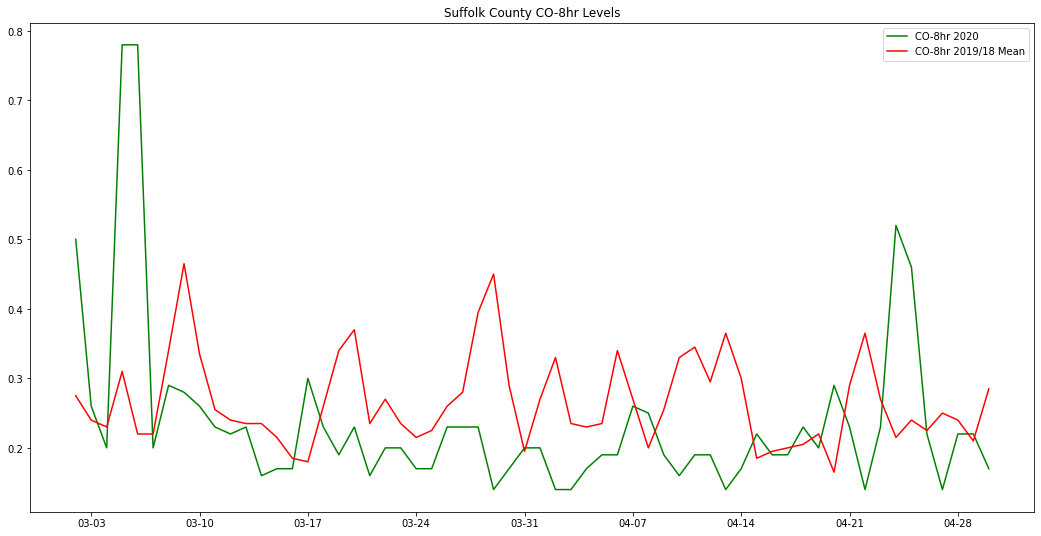



********************


Pearson Correlation: Suffolk County Cases vs PM2.5-24hr 2020              :  0.061902922246009656
Pearson Correlation: Suffolk County Cases vs PM2.5-24hr Mean of 2019, 2018:  -0.08324564001187174


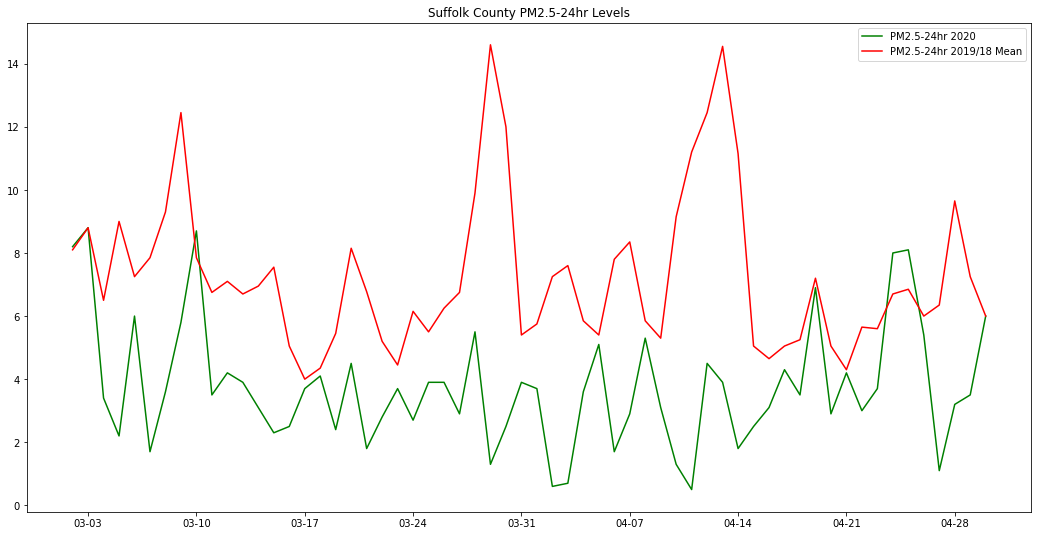



********************


Pearson Correlation: Essex County Cases vs PM2.5-24hr 2020              :  -0.23170721893452534
Pearson Correlation: Essex County Cases vs PM2.5-24hr Mean of 2019, 2018:  0.19667521171516353


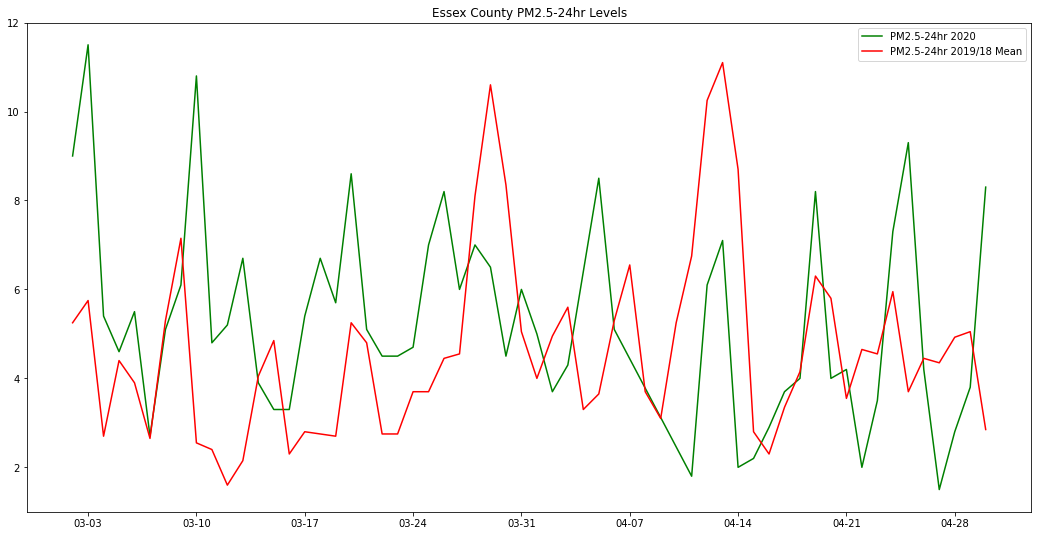



********************


Pearson Correlation: Plymouth County Cases vs PM2.5-24hr 2020              :  -0.08254956761862675
Pearson Correlation: Plymouth County Cases vs PM2.5-24hr Mean of 2019, 2018:  0.08667637955756387


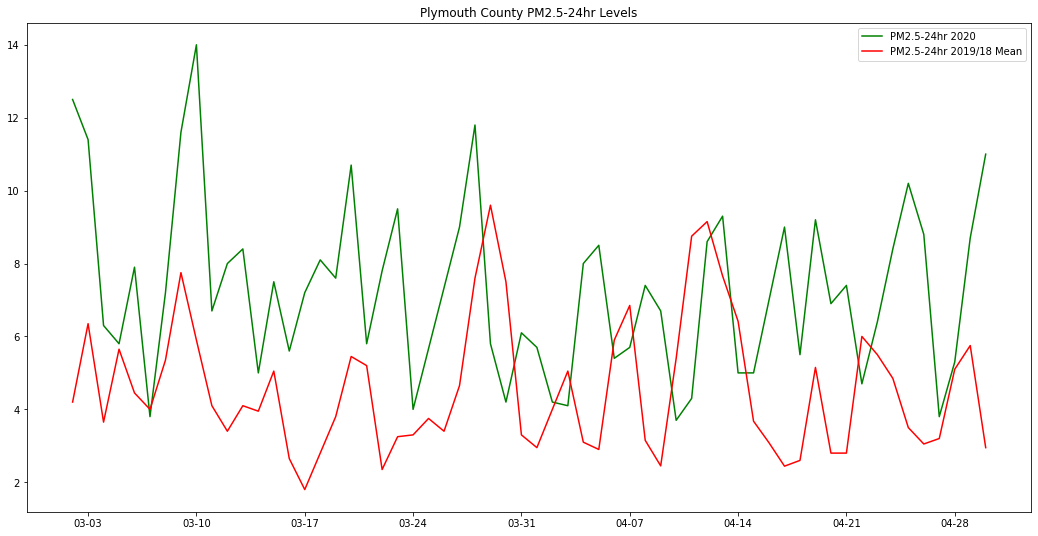



********************




In [222]:
def calculate_pearson_correlation(x, y):
  n = len(x)
  x_mean = sum(x) / len(x)
  y_mean = sum(y) / len(y)
  numerator = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(n)])
  denominator1 = sum([(xi - x_mean)**2 for xi in x]) ** 0.5
  denominator2 = sum([(yi - y_mean)**2 for yi in y]) ** 0.5
  denominator = denominator1 * denominator2
  return numerator / denominator

def calculate_correlation_and_plot(county, station, parameter):
  xc = confirmed_march_april[county].tolist()
  filtered20 = airnow_2020[(airnow_2020['AQSID'] == station) & (airnow_2020['parameter name'] == parameter)]
  filtered20 = impute_missing_dates(filtered20, '2020', confirmed_march_april['Date'].dt.strftime('2020-%m-%d').values.tolist())
  filtered19 = airnow_2019[(airnow_2019['AQSID'] == station) & (airnow_2019['parameter name'] == parameter)]
  filtered19 = impute_missing_dates(filtered19, '2019', confirmed_march_april['Date'].dt.strftime('2019-%m-%d').values.tolist())
  filtered18 = airnow_2018[(airnow_2018['AQSID'] == station) & (airnow_2018['parameter name'] == parameter)]
  filtered18 = impute_missing_dates(filtered18, '2018', confirmed_march_april['Date'].dt.strftime('2018-%m-%d').values.tolist())
  filtered17 = airnow_2017[(airnow_2017['AQSID'] == station) & (airnow_2017['parameter name'] == parameter)]
  filtered17 = impute_missing_dates(filtered17, '2017', confirmed_march_april['Date'].dt.strftime('2017-%m-%d').values.tolist())

  filtered_mean1918 = np.mean(np.vstack((filtered19['value'], filtered18['value'])), axis=0)
  print('Pearson Correlation: {} Cases vs {} 2020              : '.format(county, parameter), calculate_pearson_correlation(xc, filtered20['value']))
  print('Pearson Correlation: {} Cases vs {} Mean of 2019, 2018: '.format(county, parameter), calculate_pearson_correlation(xc, filtered_mean1918))

  plt.figure(figsize=(18,9))
  plt.plot(filtered20.index, filtered20['value'].tolist(), label='{} 2020'.format(parameter), color='green')
  plt.plot(filtered20.index, filtered_mean1918, label='{} 2019/18 Mean'.format(parameter), color='red')
  plt.title('{} {} Levels'.format(county, parameter))
  plt.legend()
  ax = plt.gca()
  date_form = DateFormatter("%m-%d")
  ax.xaxis.set_major_formatter(date_form)
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
  plt.show()

  print('\n' * 2 + '*' * 20 + '\n'*2)

correlations_metrics_options = [('Suffolk County', 250250042, 'CO-8hr'),
                                ('Suffolk County', 250250042, 'PM2.5-24hr'),
                                ('Essex County', 250092006, 'PM2.5-24hr'),
                                ('Plymouth County', 250230005, 'PM2.5-24hr')]

for option in correlations_metrics_options:
  calculate_correlation_and_plot(option[0], option[1], option[2])

### Pearson Correlation Review Analysis

### **NOTE:** We only plot for years and stations where there was data to make meaningful inferences.

**CO Levels:** This data was available only for Suffolk County.

Notice that the Pearson Correlation for number of cases vs Carbon Monoxide levels for 2019 and 2018 mean is very close to 0 but that is the case with 2020 levels as well. 

**Lead Levels:**
We can see a similar trend with Lead levels as well for Suffolk and Plymouth counties. But for Essex even though the magintudes of the correlation are comparative to others but they are in opposite directions.

**Graphs:**
The graphs are indicative of the drop one can see in the levels over the months of March and April and slight drop over time. Also note that the values for 2020 are below the mean of previous 2 years significantly (barring a few spikes) in general but we can not significantly say that impact can be attributed to the increasing number of confirmed cases.

**This puts into perspective the possible impact of COVID-19 on the Air Pollution parameters.**

# Required Inference #5 (Done)

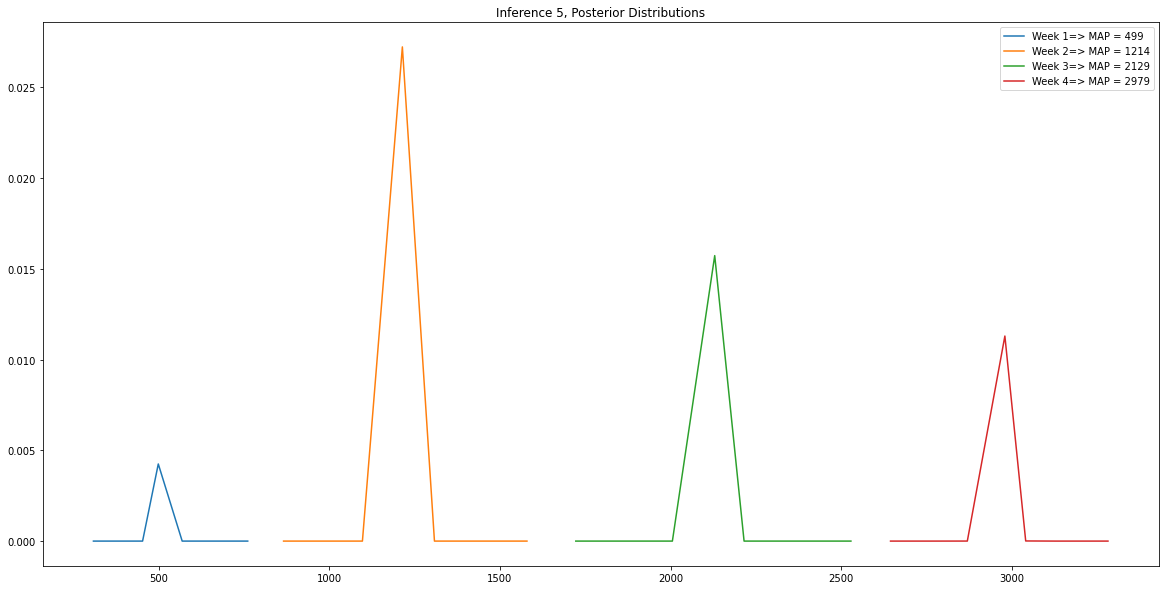

In [223]:
deaths4weeks = deaths2.iloc[-28:] # filtering last 28 days - 4 weeks
deaths4weeks = np.array_split(deaths4weeks.sum(1), 4) # dividing into 4 different weeks

post_list = []
map_list = []

# possion data with exponential prior gives gamma posterior (same distribution in subsequent iterations)
# gamma distribution will have alpha = sum(x) + 1 and beta = n + (mean(data))^-1
# proof shared in drive

for data in deaths4weeks:
  alpha = sum(data) + 1
  beta = len(data) + (1/np.mean(data))
  posterior = [gamma.pdf(x, a=alpha, scale=1/beta) for x in data]
  post_list.append(posterior)
  map_list.append(list(data)[np.argmax(posterior)]) # map is x values where posterior is highest

for i, (data, post) in enumerate(zip(deaths4weeks, post_list)):
  plt.plot(data, post, label='Week '+str(i+1) + '=> MAP = ' + str(map_list[i]))
plt.legend()
plt.title('Inference 5, Posterior Distributions')
plt.show()

If we implement gamma pdf function by ourselves, it gives overflow error

In [0]:
# def gamma_dist(x, alpha, beta):
#   # https://en.wikipedia.org/wi ki/Gamma_distribution
#   return ((beta**(-alpha))*(x**(alpha-1))*(np.exp((-x/beta))))/scipy.math.factorial(alpha-1)

# deaths4weeks = deaths2.iloc[-28:] # filtering last 28 days - 4 weeks
# deaths4weeks = np.array_split(deaths4weeks.sum(1), 4) # dividing into 4 different weeks

# for data in deaths4weeks:
#   alpha = sum(data) + 1
#   beta = len(data) + (1/np.mean(data))
#   # posterior = [gamma.pdf(x, a=alpha, scale=1/beta) for x in data]  # direct scipy function for gamma (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)
#   posterior = [gamma_dist(x, alpha, 1/beta) for x in data]           # our function giving overflow error
#   post_list.append(posterior)
#   map_list.append(list(data)[np.argmax(posterior)]) # map is x values where posterior is highest

# for i, (data, post) in enumerate(zip(deaths4weeks, post_list)):
#   plt.plot(data, post, label='Week '+str(i+1) + '=> MAP = ' + str(map_list[i]))
# plt.legend()
# plt.title('Inference 5, Posterior Distributions')
# plt.show()

# Creative Inference #1

We look to apply KS Test to see how similar are distributions for Carbon Monoxide and Lead levels from station in Suffolk County, and Lead levels for Essex and Plymouth counties for years 2020 and previous years. 

In [225]:
def calculate_KS_for(county, station, parameter):
  filtered20 = airnow_2020[(airnow_2020['AQSID'] == station) & (airnow_2020['parameter name'] == parameter)]
  filtered20 = impute_missing_dates(filtered20, '2020', confirmed_march_april['Date'].dt.strftime('2020-%m-%d').values.tolist())
  filtered19 = airnow_2019[(airnow_2019['AQSID'] == station) & (airnow_2019['parameter name'] == parameter)]
  filtered19 = impute_missing_dates(filtered19, '2019', confirmed_march_april['Date'].dt.strftime('2019-%m-%d').values.tolist())
  filtered18 = airnow_2018[(airnow_2018['AQSID'] == station) & (airnow_2018['parameter name'] == parameter)]
  filtered18 = impute_missing_dates(filtered18, '2018', confirmed_march_april['Date'].dt.strftime('2018-%m-%d').values.tolist())
  
  critical_value = 0.05
  print("H0: The data for the metric in 2020 and 2019 come from the same distribution.")
  print('KS Test: {} for {} 2020 vs 2019: '.format(county, parameter))
  KS(filtered20['value'].tolist(), filtered19['value'].tolist(), critical_value)
  print('\n' * 1 + '*' * 20 + '\n'*1)
  print("H0: The data for the metric in 2019 and 2018 come from the same distribution.")
  print('KS Test: {} for {} 2019 vs 2018: '.format(county, parameter))
  KS(filtered19['value'].tolist(), filtered18['value'].tolist(), critical_value)

  print('\n' * 2 + '*' * 20 + '\n'*2)

KS_metrics_options = [('Suffolk County', 250250042, 'CO-8hr'),
                      ('Suffolk County', 250250042, 'PM2.5-24hr'),
                      ('Essex County', 250092006, 'PM2.5-24hr'),
                      ('Plymouth County', 250230005, 'PM2.5-24hr')]

for option in KS_metrics_options:
  calculate_KS_for(option[0], option[1], option[2])

H0: The data for the metric in 2020 and 2019 come from the same distribution.
KS Test: Suffolk County for CO-8hr 2020 vs 2019: 
Rejecting null hypothesis because D value = 0.4666666666666675 greater than or equal to 0.05.

********************

H0: The data for the metric in 2019 and 2018 come from the same distribution.
KS Test: Suffolk County for CO-8hr 2019 vs 2018: 
Rejecting null hypothesis because D value = 0.2333333333333333 greater than or equal to 0.05.


********************


H0: The data for the metric in 2020 and 2019 come from the same distribution.
KS Test: Suffolk County for PM2.5-24hr 2020 vs 2019: 
Rejecting null hypothesis because D value = 0.7333333333333342 greater than or equal to 0.05.

********************

H0: The data for the metric in 2019 and 2018 come from the same distribution.
KS Test: Suffolk County for PM2.5-24hr 2019 vs 2018: 
Rejecting null hypothesis because D value = 0.4333333333333338 greater than or equal to 0.05.


********************


H0: The 

### **NOTE:** We only calculate for years and stations where there was data to make meaningful inferences.

In order to compare the distributions for certain metrics we perform the KS test to see if the values for 2020 and 2019 are similar and as a baseline if we see 2019 and 2018 comparison.

Our Null hypothesis is that they follow datasets we are comparing come from the same distribution. In all of the cases we can see that we reject the Null hypothesis. This does NOT give us much insight. 

An important metric to compare the KS-statistic values which are smaller for the test for 2018 and 2019 in comparison to the test for comparing 2020 and 2019 in the case of Suffolk county.

We observe the opposite trend for Essex and Plymouth counties.

# Creative inference #2

Male Vs Female


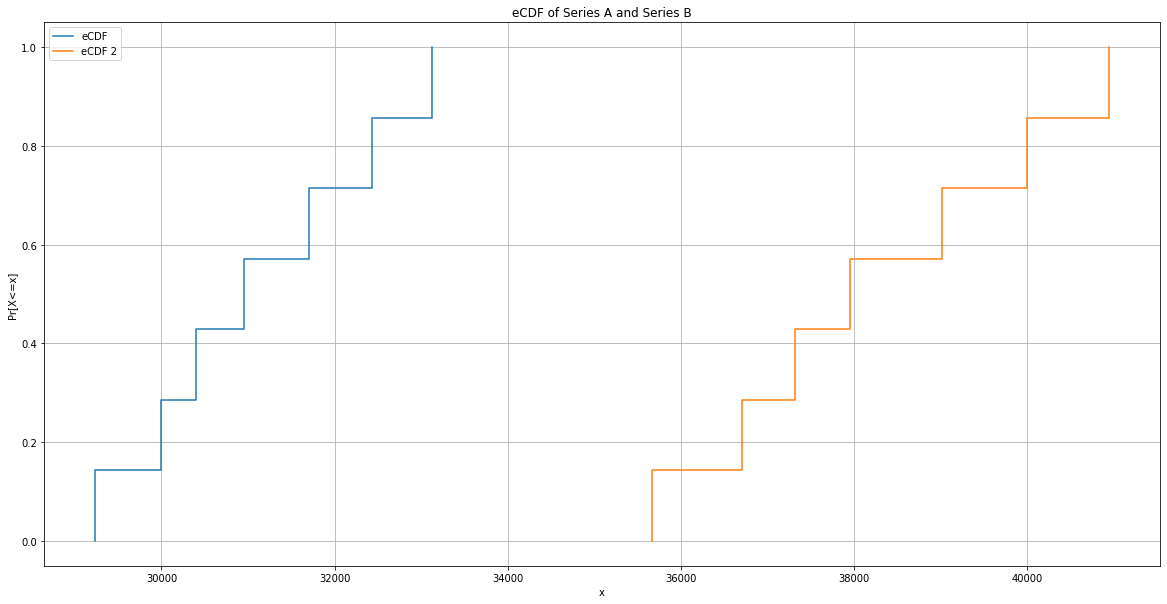

Rejecting null hypothesis because D value = 0.9999999999999998 greater than or equal to 0.05.
Males Vs Female for 2000 permutations: Rejecting null hypothesis. p value: 0.0


In [226]:
age = pd.read_csv('extractedData/Age.csv')
sex = pd.read_csv('extractedData/Sex.csv')
sex_data=sex.tail(7)
KS( sex_data['Male'].tolist(), sex_data['Female'].tolist(), 0.05, message="Male Vs Female",draw=True)
n = 2000
alpha = 0.05
p_value = calc_p_val(sex_data['Male'].tolist(), sex_data['Female'].tolist(), n)
p_values.append(p_value)
result = test_hypothesis(p_value, alpha, "Males Vs Female for {} permutations: ".format(n))

The null hypothesis for KS Test is that Male and Female distribution is the same distribution. The results show that they are not the same distribution. 


The null hypothesis of permutation test is that the male and female cases distribution is same. The hypothesis is rejected and hence it rejects that the distribution of deaths of male and female is not different and hence it is same.

# Creative Inference #3

Difference in Pollution means before and after Stay-at-Home directive


In [0]:
air_qual = pd.read_csv('AirNow/AirNow_Massachusetts_2020_WithCounties.csv')

In [0]:
air_qual = air_qual[['Valid date', 'site name', 'parameter name', 'reporting units', 'value', 'AQI', 'county']]

In [0]:
STD_DATE_FORMAT = '%m/%d/%Y'
DATA_DATE_FORMAT = '%m/%d/%y'
air_qual['Valid date'] = pd.to_datetime(air_qual['Valid date'], format=DATA_DATE_FORMAT).dt.strftime(STD_DATE_FORMAT)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

#Remove outliers from pollution data by Tukey's Rule
def remove_outliers(air_qual_reqd):
  x = np.copy(air_qual_reqd['value'].values)
  x.sort()
  q_1 = x[len(x)//4]
  q_3 = x[3*len(x)//4]
  iqr = q_3-q_1

  iqr_1 = q_1 - 1.5 * iqr
  iqr_3 = q_3 + 1.5 * iqr
  outliers = x[(x<iqr_1) | (x>iqr_3)]
  print("{} outliers found, {}".format(len(outliers),outliers))
  air_qual_reqd = air_qual_reqd[~air_qual_reqd['value'].isin(outliers)]
  #plt.hist(air_qual_reqd.value, histtype='step')
  #Plot the sample distribution
  sns.distplot(air_qual_reqd.value, hist=False)
  plt.pause(1)
  plt.show

In [0]:
def t_test_2sample_unpaired(sample1, sample2):
  #Critical values from https://www.itl.nist.gov/div898/handbook/eda/section3/eda3672.htm
  critical_val_dict = {20:-1.725,19:-1.729,18:-1.734,17:-1.740,}
  mean_sample1 = sample1.mean()
  mean_sample2 = sample2.mean()
  variance_sample1 = sample1.var()
  variance_sample2 = sample2.var()
  t_stat = (mean_sample1 - mean_sample2) / math.sqrt( variance_sample1/len(sample1) + variance_sample2/len(sample2))
  dfreedom = min(len(sample1), len(sample2))-1
  if dfreedom in critical_val_dict:
    t_critical = critical_val_dict[dfreedom]
  else:
    raise Exception("Not enough sample points to compare after removing outliers")  
  print('Value of t-stat for critical value {} at n-1 = {} & alpha 0.05 = {}'.format(t_critical, dfreedom, t_stat))
  if t_stat < t_critical:
    return False
  else:
    return True
      

In [0]:
import math

#County:Site dictionary to obtain pollution data from Dataset
county_site_dict = {'Middlesex':'ChelmsfordNR', 'Suffolk':'Boston - Roxbury', 'Bristol': 'Fall River', 'Essex': 'Haverhill', 'Plymouth':'Brockton'}
pollution_param = ['OZONE-8HR', 'PM2.5-24hr']

def calc_pollution_significance(county):
  if county in county_site_dict:
    for param in pollution_param:
      print(param)
      site = county_site_dict[county]
      air_qual_reqd = air_qual[(air_qual['county']==county) & (air_qual['site name']==site) & (air_qual['parameter name']==param)]
      remove_outliers(air_qual_reqd)
      prior_data = air_qual_reqd[(air_qual_reqd['Valid date'] >= '03/01/2020')][:20]
      after_data = air_qual_reqd[(air_qual_reqd['Valid date'] >= '04/05/2020')][:20]
      try:
        result = t_test_2sample_unpaired(prior_data['value'], after_data['value'])
        if not result:
          print('H0 is rejected, Mean before stay-at-home is not greater than after stay-at-home order')
        else:
          print("Can't reject H0, Mean before stay-at-home could be greater than after stay-at-home order")
        print('\n')  
      except:
        print('Not enough data points to calculate significance')      

Suffolk
OZONE-8HR
1 outliers found, [55.]


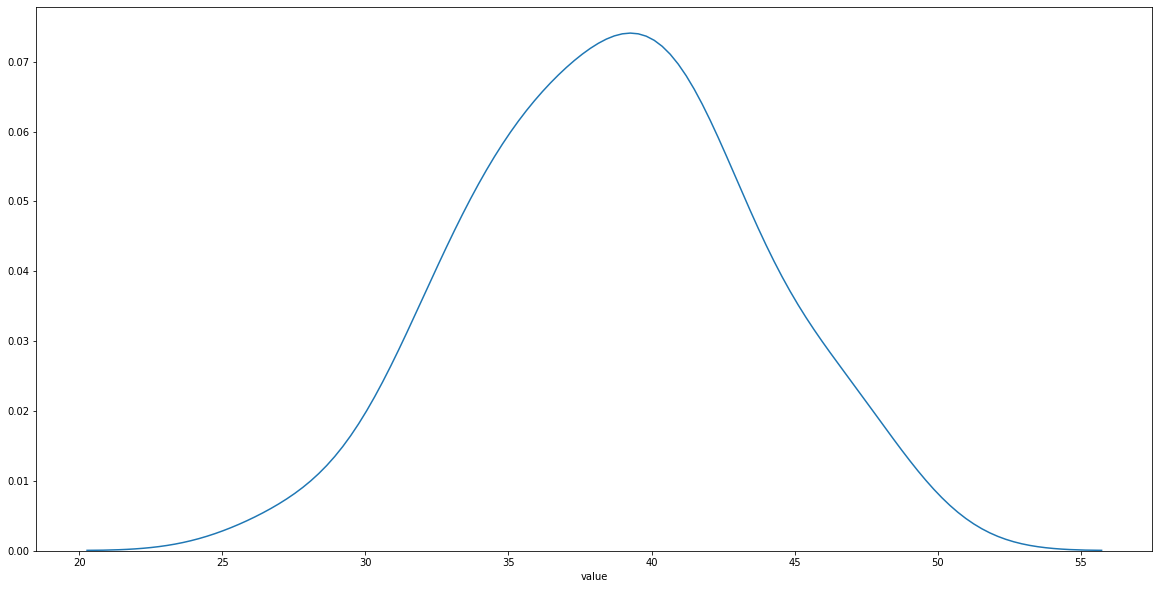

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = -2.0337009569766686
H0 is rejected, Mean before stay-at-home is not greater than after stay-at-home order


PM2.5-24hr
5 outliers found, [8.  8.1 8.2 8.7 8.8]


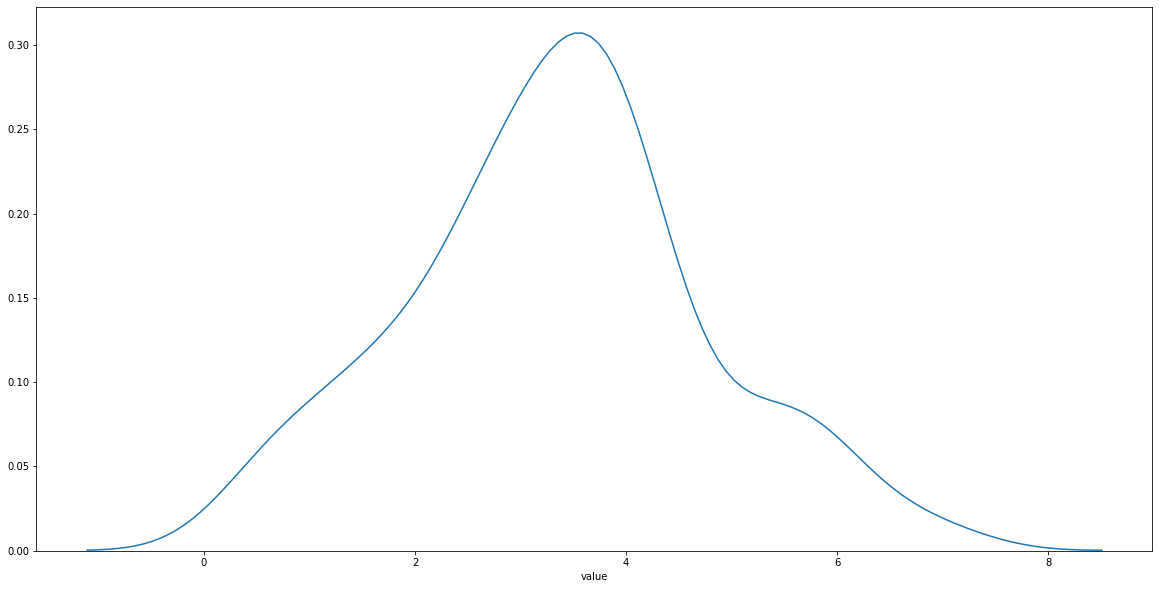

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = 1.153701446227327
Can't reject H0, Mean before stay-at-home could be greater than after stay-at-home order


Middlesex
OZONE-8HR
3 outliers found, [22. 29. 52.]


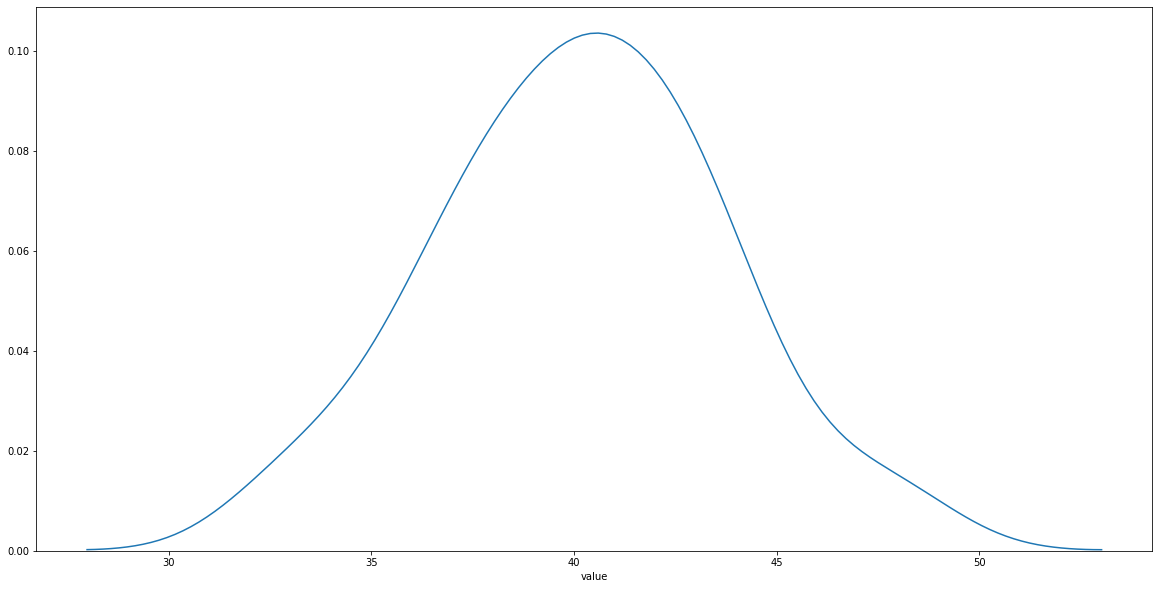

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = -2.24768650807746
H0 is rejected, Mean before stay-at-home is not greater than after stay-at-home order


PM2.5-24hr
2 outliers found, [11.3 12.3]


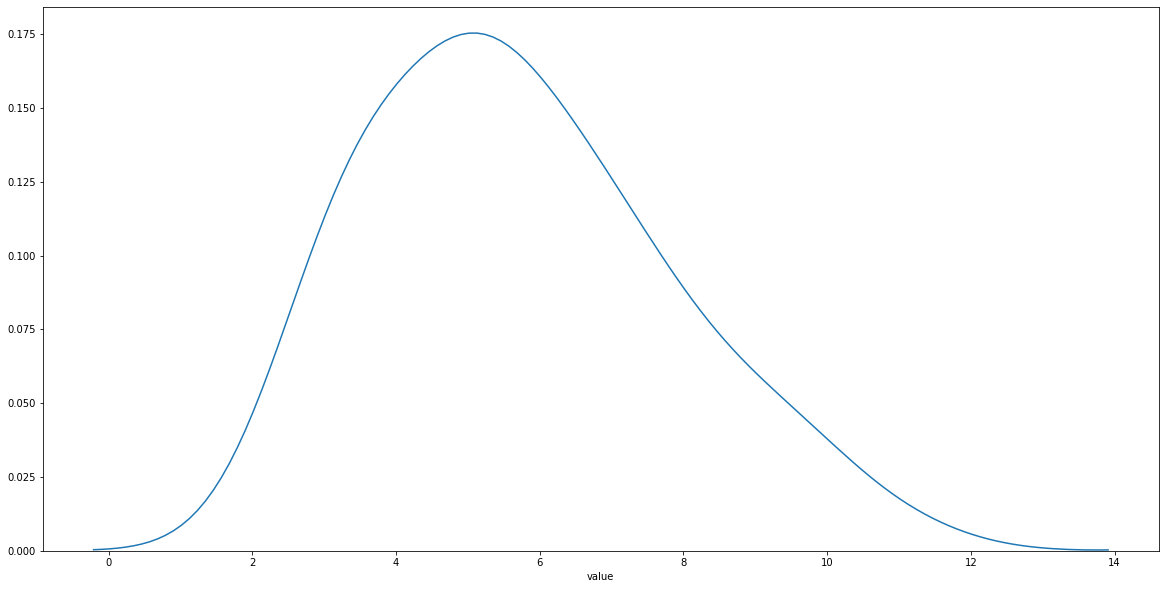

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = -0.7758578263001827
Can't reject H0, Mean before stay-at-home could be greater than after stay-at-home order


Essex
OZONE-8HR
2 outliers found, [32. 54.]


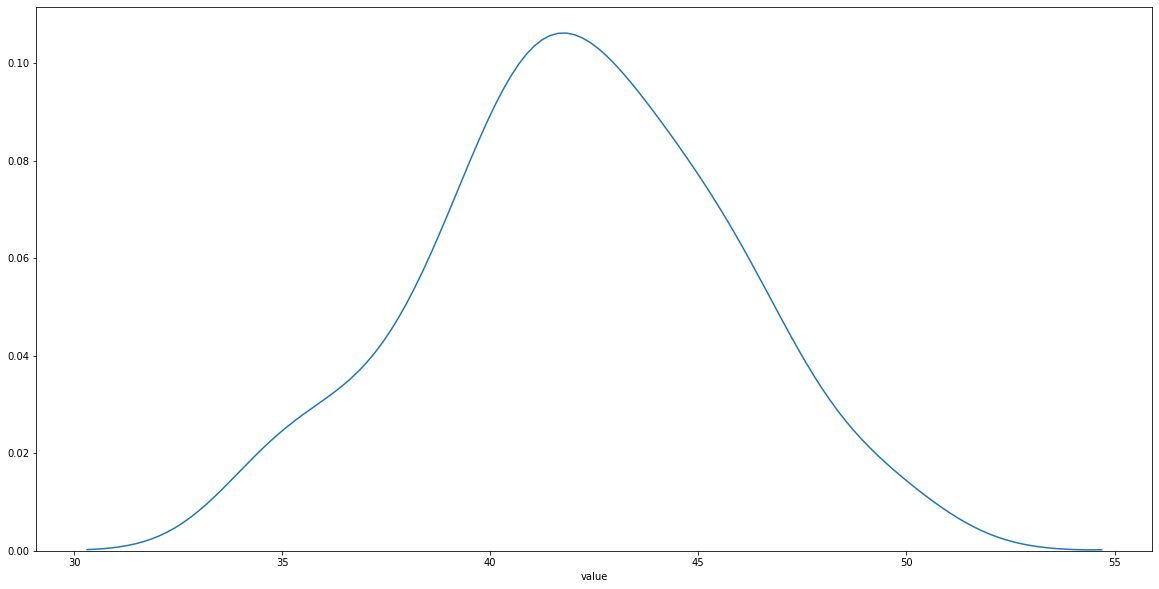

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = -1.8251218407216985
H0 is rejected, Mean before stay-at-home is not greater than after stay-at-home order


PM2.5-24hr
2 outliers found, [7.9 8.5]


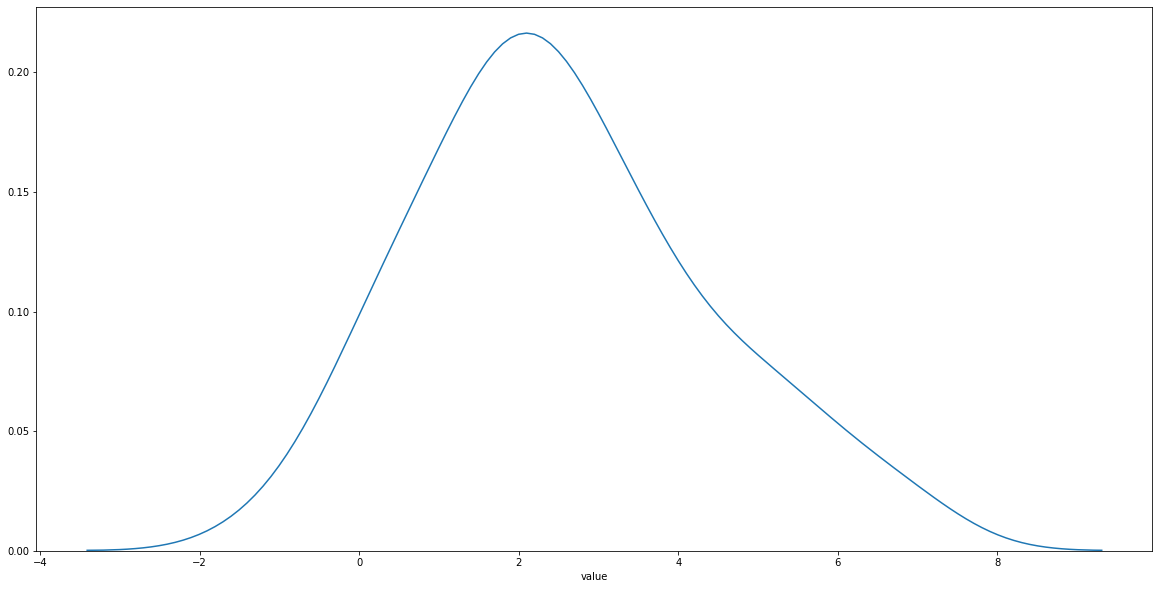

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = 0.2559960557948599
Can't reject H0, Mean before stay-at-home could be greater than after stay-at-home order


Bristol
OZONE-8HR
0 outliers found, []


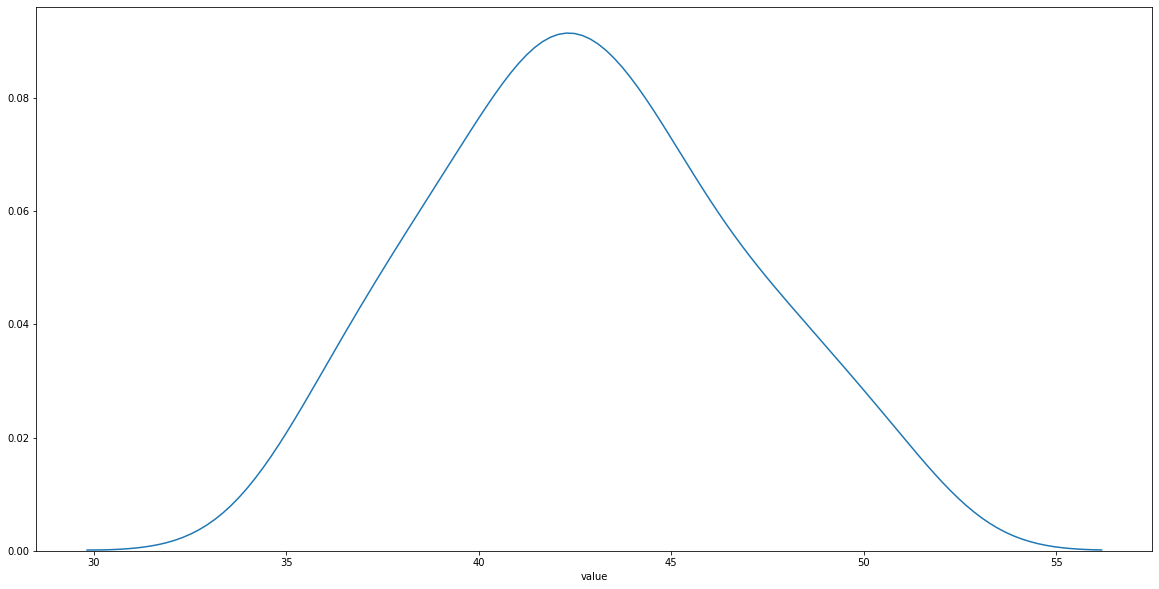

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = -2.3967930416912835
H0 is rejected, Mean before stay-at-home is not greater than after stay-at-home order


PM2.5-24hr
5 outliers found, [ 3.2  4.1 15.5 17.1 20.5]


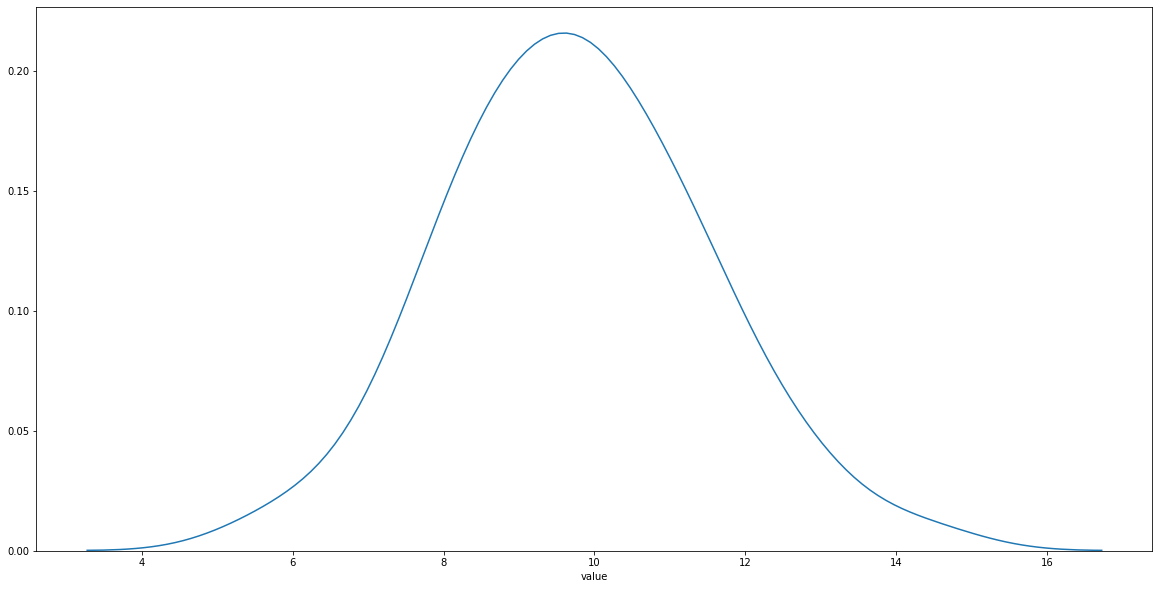

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = 0.7394965702623602
Can't reject H0, Mean before stay-at-home could be greater than after stay-at-home order


Plymouth
OZONE-8HR
0 outliers found, []


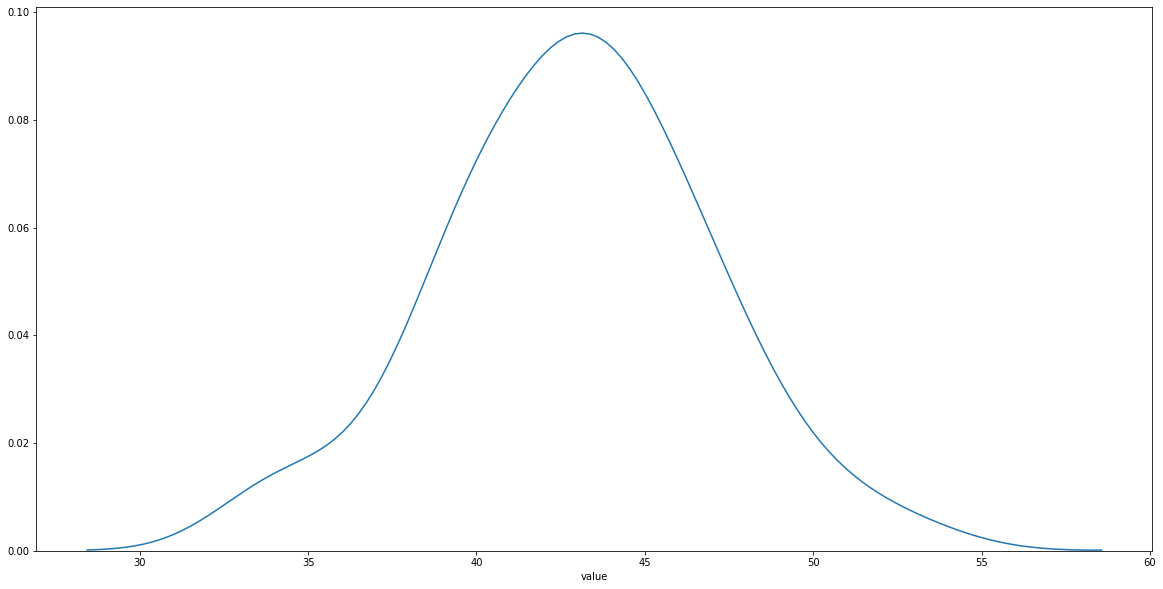

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = -2.9668398292705853
H0 is rejected, Mean before stay-at-home is not greater than after stay-at-home order


PM2.5-24hr
1 outliers found, [14.]


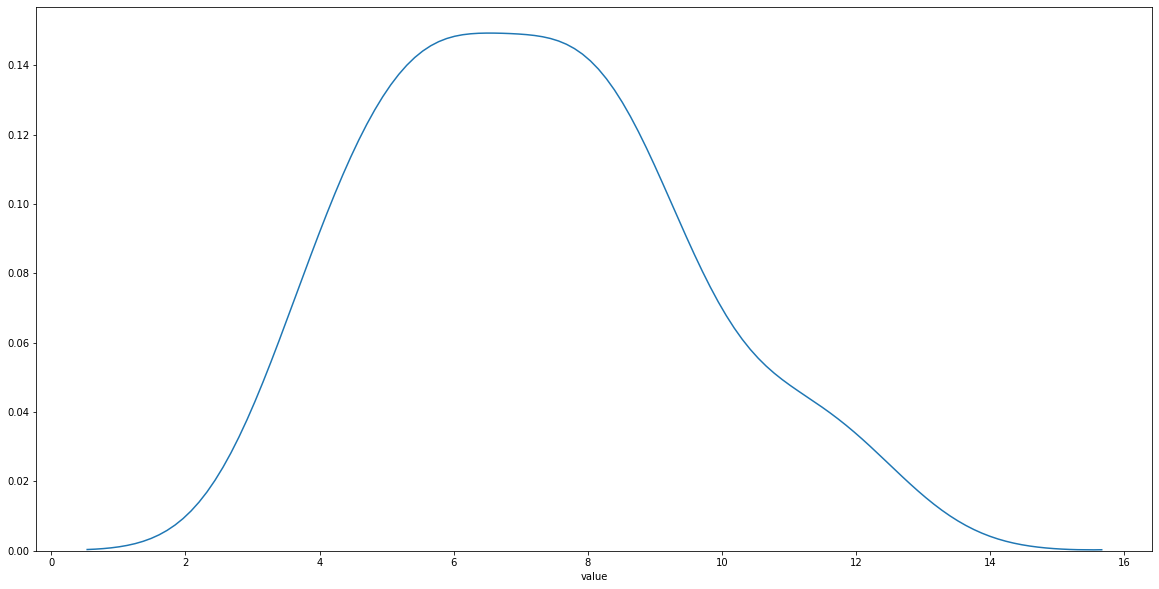

Value of t-stat for critical value -1.729 at n-1 = 19 & alpha 0.05 = 1.8780567879764116
Can't reject H0, Mean before stay-at-home could be greater than after stay-at-home order




In [233]:
import time
pollution_counties_list = ['Suffolk', 'Middlesex', 'Essex', 'Bristol', 'Plymouth']
for county in pollution_counties_list:
  print(county)
  calc_pollution_significance(county)


In [234]:
try:
  result = t_test_2sample_unpaired(prior_data['value'], after_data['value'])
  if not result:
    print('H0 is rejected', 'Mean before stay-at-home is not greater than after stay-at-home order')
  else:
    print("Can't reject H0")
except:
  print('Not enough data points to calculate significance')      

Not enough data points to calculate significance


**Comments**

---

As per https://ballotpedia.org/States_with_lockdown_and_stay-at-home_orders_in_response_to_the_coronavirus_(COVID-19)_pandemic,_2020#Orders_by_state

Governor of Massachusetts gave a stay at home order starting March 24. <br>
Here,we are hypothesising that the air quality would get better due to people staying at home and commute getting scarce. Hence, the Ozone and PM2.5, which is particulate data were compared for 20 days before and after the order was given.<br>
The before and after data is from the start of March and April months respectively.<br>
The hypothesis here is that mean value of the particulate matters in air before the announcement were more than after.<br>
The data is taken from AirNow, and for the consideration period outliers were removed for each County, and then the data was plotted before applying hypothesis testing.<br>
Since the data seems approximately Normal, and also 20 records were considered for each sample,Unpaired T-test was applied to compare the sample mean estimators.<br>
As per the results, the ground level Ozone doesn't seem to be impacted which maybe due to the fact that it takes a long time in general for the Ozone concentration to change which is a general longer term climate consideration.<br>
On the other hand, the hypothesis for PM2.5 can't be rejected which maybe due to the fact that due to fewer people gathering together and most of all travelling, the quantity of particulate matter might be going down.
